## 1 Load packages and data

In [1]:
import glob
import numpy as np
import pandas as pd
import h5flow
import h5py
import matplotlib.pyplot as plt
import yaml
import os

import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib
import csv

from h5flow.data import dereference
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable
from sklearn.cluster import DBSCAN
import numpy as np

plot_dir = 'pde_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

save_dir = 'pde_files'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [8]:
#Load data

# folder selected muons
directory_selected_muons = "/global/homes/m/mnuland/backtracking/light-efficiency/pde_ndlar_prototype/pde_2x2/"
mu_file_pattern = "*.csv"
file_list_muons = sorted(glob.glob(os.path.join(directory_selected_muons, mu_file_pattern)))

# directories containing all .hdf5 files of cosmics data
directory1 = "/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july8_2024/nominal_hv/"
# directory2 = "/global/cfs/cdirs/dune/www/data/FSD/reflows/v7/flow/cosmics/08Nov2024/"
file_pattern = "packet-0050017-2024_07_08_14_03_28_CDT.FLOW.hdf5"

file_list1 = sorted(glob.glob(os.path.join(directory1, file_pattern)))
# file_list2 = sorted(glob.glob(os.path.join(directory2, file_pattern)))
file_list = file_list1 #+ file_list2

# Create a dictionary for FAST filename lookup
# e.g. "packet-0020113-2024_11_07_19_47_26_CET.FLOW_v7.hdf5" -> full path
hdf5_map = {os.path.basename(path): path for path in file_list}

rank = 0 #replace this with int(os.environ["SLURM_PROCID"] when using SLURM on nersc

csv_file = file_list_muons[rank]

csv_basename = os.path.basename(csv_file) # Get only the filename: packet-xxx.hdf5.csv

hdf5_name = csv_basename.replace(".csv", "") # Remove the trailing ".csv"

hdf5_path = hdf5_map.get(hdf5_name) # Look up the corresponding HDF5 path

df_mu = pd.read_csv(csv_file) # load the csv of muon selections
p_events = df_mu["ev_id"].astype(int).tolist()# load event IDs from the CSV

f = h5flow.data.H5FlowDataManager(hdf5_path, "r")



## 2 Functions

### 2.1 2x2 light fraction calculation

In [9]:
# Approach 2x2
def compute_light_fraction(x, y, z, dE, x0, x1, y0, y1, z_det):
    """
    Compute the fraction of scintillation light reaching a rectangular detector
    from a muon track in liquid argon, considering recombination and geometry.

    Parameters:
        x, y, z : arrays of muon track coordinates (length N)
        dE : array of energy deposited at each step (length N-1 or N)
        x0, x1, y0, y1 : float, detector boundaries in x and y
        z_det : float, z-position of detector plane

    Returns:
        float: fraction of total scintillation light that reaches the detector
    """
    # Constants
    Y_gamma = 24000           # photons per MeV at 500 V/cm
    # Y_gamma = 68400           # photons per MeV at 500 V/cm
    # Y_gamma =             # photons per MeV at 500 V/cm for MPV
    alpha = 0.093             # recombination parameter (1/MeV⋅cm)
    dEdx_muon = 2.1           # MeV/cm, MIP energy loss in LAr
    total_produced = 0.0
    total_detected = 0.0

    # Loop over segments between consecutive track points
    for i in range(len(x) - 1):
        # Step midpoint (photon emission assumed here)
        x_mid = 0.5 * (x[i] + x[i+1])
        y_mid = 0.5 * (y[i] + y[i+1])
        z_mid = 0.5 * (z[i] + z[i+1])
        
        # Step length
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        dz = z[i+1] - z[i]
        step_length = np.sqrt(dx**2 + dy**2 + dz**2)  # cm

        if step_length == 0:
            continue  # skip degenerate step

        if dE[i] < 0:
            dE[i] = 0.0 # ignore negative energy depositions

        # Local dE/dx and recombination correction
        epsilon = 1e-2  # small number to prevent divide-by-zero
        #dedx_local = dE[i] / step_length if (step_length > epsilon and dE[i]>0) else dEdx_muon # MeV/cm
        dedx_local = dEdx_muon
        R = np.log(1 + alpha / dedx_local) / (alpha / dedx_local)
        # Total photons produced in this step
        #N_gamma = Y_gamma * dE[i]*1.4 * R 
        N_gamma = Y_gamma * dEdx_muon*step_length * R 
        total_produced += N_gamma

        # Compute analytical solid angle from step coordinates to detector
        omega = solid_angle_rectangle(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det)
        #omega = solid_angle_rect_asin_grid_zplane(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det) #livio
        
        if omega < 0:
            omega = 0.0
            print("Warning: Solid angle is negative. Check geometry.")
        fraction_reaching = omega / (4 * np.pi)
        total_detected += fraction_reaching * N_gamma

    return total_detected, total_produced, total_detected / total_produced if total_produced > 0 else 0.0

def solid_angle_rectangle(x_s, y_s, z_s, x0, x1, y0, y1, z_det):
    """
    Compute the solid angle subtended by a rectangle at position z_det
    as seen from point (x_s, y_s, z_s), using analytical geometry.

    Returns:
        float: solid angle in steradians
    """
    z = np.abs(z_det - z_s)
    omega = 0.0
    for i, xi in enumerate([x0, x1]):
        for j, yj in enumerate([y0, y1]):
            sign = (-1)**(i + j)
            dx = xi - x_s
            dy = yj - y_s
            r = np.sqrt(dx**2 + dy**2 + z**2)
            if z != 0:
                omega += sign * np.arctan((dx * dy) / (z * r))
    return omega


In [10]:
print(hdf5_name)

packet-0050017-2024_07_08_14_03_28_CDT.FLOW.hdf5


In [11]:
print(f["/charge/events/data"])

<HDF5 dataset "data": shape (9594,), type "|V52">


### 2.2 3D linefit (Jans original code)

In [12]:
#### with linearfit
def line_fit_3d_segment_midpoints(x, y, z, seg_length):
    """
    Fit a straight line in 3D using PCA (SVD), segment it,
    and return midpoints + segment lengths.
    """

    if len(x) < 2:
        print("no charge hits!!!!!!!!!!!! to fit")
        return [], [], [],[] 

    # --- 1) Fit straight line via SVD (total least squares) ---
    pts = np.column_stack((x, y, z))  # (N, 3)
    centroid = pts.mean(axis=0)

    # SVD of centered coordinates
    _, _, vt = np.linalg.svd(pts - centroid)
    direction = vt[0]                # principal direction
    direction /= np.linalg.norm(direction)

    # --- 2) Compute t = projection of each point onto the fitted line ---
    # Equivalent to dot(pts[i] - centroid, direction) for each i
    dx = pts[:, 0] - centroid[0]
    dy = pts[:, 1] - centroid[1]
    dz = pts[:, 2] - centroid[2]

    t = dx * direction[0] + dy * direction[1] + dz * direction[2]

    t_min, t_max = t.min(), t.max()
    total_length = t_max - t_min

    if total_length <= 0:
        raise ValueError("All points are identical or degenerate.")

    # --- 3) Build segment edges along fitted line ---
    t_edges = np.arange(t_min, t_max, seg_length)
    if t_edges[-1] < t_max:
        t_edges = np.append(t_edges, t_max)

    # Midpoints in parameter space
    t_mid = 0.5 * (t_edges[:-1] + t_edges[1:])

    # --- 4) Convert midpoints into 3D coordinates explicitly ---
    x_mid = centroid[0] + t_mid * direction[0]
    y_mid = centroid[1] + t_mid * direction[1]
    z_mid = centroid[2] + t_mid * direction[2]

    # Segment lengths (straight along t)
    step_length = np.diff(t_edges)

    return x_mid, y_mid, z_mid, step_length

def compute_light_fraction_w_liner_fit(x, y, z, dE, x0, x1, y0, y1, z_det):
    """
    Compute the fraction of scintillation light reaching a rectangular detector
    from a muon track in liquid argon, considering recombination and geometry.

    Parameters:
        x, y, z : arrays of muon track coordinates (length N)
        dE : array of energy deposited at each step (length N-1 or N)
        x0, x1, y0, y1 : float, detector boundaries in x and y
        z_det : float, z-position of detector plane

    Returns:
        float: fraction of total scintillation light that reaches the detector
    """
    # Constants
    Y_gamma = 24000           # photons per MeV at 500 V/cm
    # Y_gamma = 68400           # photons per MeV at 500 V/cm
    # Y_gamma =             # photons per MeV at 500 V/cm for MPV
    alpha = 0.093             # recombination parameter (1/MeV⋅cm)
    dEdx_muon = 2.1           # MeV/cm, MIP energy loss in LAr
    total_produced = 0.0
    total_detected = 0.0

    seg_length = 0.1 #cm

    x_mid_a, y_mid_a, z_mid_a, step_length_a = line_fit_3d_segment_midpoints(x, y, z, seg_length)


    # Loop over segments between consecutive track points
    for i in range(len(x_mid_a)):
        # Step midpoint (photon emission assumed here)
        x_mid = x_mid_a[i]
        y_mid = y_mid_a[i]
        z_mid = z_mid_a[i]

        step_length = step_length_a[i]  # cm

        if step_length == 0:
            continue  # skip degenerate step

        #if dE[i] < 0:
        #    dE[i] = 0.0 # ignore negative energy depositions

        # Local dE/dx and recombination correction
        epsilon = 1e-2  # small number to prevent divide-by-zero
        #dedx_local = dE[i] / step_length if (step_length > epsilon and dE[i]>0) else dEdx_muon # MeV/cm
        dedx_local = dEdx_muon
        R = np.log(1 + alpha / dedx_local) / (alpha / dedx_local)
        # Total photons produced in this step
        #N_gamma = Y_gamma * dE[i] * R
        N_gamma = Y_gamma * dEdx_muon*step_length * R 
        total_produced += N_gamma

        # Compute analytical solid angle from step coordinates to detector
        omega = solid_angle_rectangle(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det)
        #omega = solid_angle_rect_asin_grid_zplane(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det) #livio

        if omega < 0:
            omega = 0.0
            print("Warning: Solid angle is negative. Check geometry.")
        fraction_reaching = omega / (4 * np.pi)
        total_detected += fraction_reaching * N_gamma

    return total_detected, total_produced, total_detected / total_produced if total_produced > 0 else 0.0


def compute_light_fraction_from_line_midpoints(x_mid, y_mid, z_mid, step_length,
                                               x0, x1, y0, y1, z_det):
    """
    Compute expected light for a rectangular detector from a pre-defined
    straight track, given by segment midpoints and lengths.

    Parameters
    ----------
    x_mid, y_mid, z_mid : 1D arrays
        Segment midpoints (cm).
    step_length : 1D array
        Segment lengths (cm), same length as x_mid.
    x0, x1, y0, y1 : float
        Detector rectangle boundaries in x and y.
    z_det : float
        z position of detector plane.

    Returns
    -------
    total_detected, total_produced, fraction_detected
    """
    # Constants
    Y_gamma = 24000       # photons per MeV at 500 V/cm
    alpha   = 0.093       # recombination parameter (1/MeV·cm)
    dEdx_muon = 2.1       # MeV/cm, MIP energy loss in LAr

    total_produced = 0.0
    total_detected = 0.0

    # recombination factor for MIP
    R = np.log(1 + alpha / dEdx_muon) / (alpha / dEdx_muon)

    for xm, ym, zm, L in zip(x_mid, y_mid, z_mid, step_length):
        if L <= 0:
            continue

        # photons in this segment
        N_gamma = Y_gamma * dEdx_muon * L * R
        total_produced += N_gamma

        # solid angle from this segment to the rectangle
        omega = solid_angle_rectangle(xm, ym, zm, x0, x1, y0, y1, z_det)
        if omega < 0:
            omega = 0.0

        frac = omega / (4 * np.pi)
        total_detected += frac * N_gamma

    fraction = total_detected / total_produced if total_produced > 0 else 0.0
    return total_detected, total_produced, fraction


def plot_light_on_detectors(x, y, z, dE, detector_rects, z_dets, ax=None):
    """
    Plot the muon track and rectangles (detectors) with shading based on received light.

    Parameters:
        x, y, z : muon track hit coordinates
        dE : energy deposition at each hit
        detector_rects : list of tuples [(x0, y0, x1, y1), ...] #(x_min, y_min, x_max, y_max)
        z_dets : list of z positions of the detector planes
    """
    results = []  # Store (x0, y0, x1, y1, z_det, fraction)
    # Compute light fraction for each rectangle at each z plane
    for z_det in z_dets:
        for (x0, y0, x1, y1) in detector_rects:
            #det, prod, frac = compute_light_fraction(x, y, z, dE, x0, x1, y0, y1, z_det)
            det, prod, frac = compute_light_fraction_w_liner_fit(x, y, z, dE, x0, x1, y0, y1, z_det) 
            # old one: det, prod, frac = compute_light_fraction(x, y, z, dE, x0, x1, y0, y1, z_det):
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [13]:
# below are the two new light generating functions with a exponential reduction factor
def compute_light_fraction_w_liner_fit(x, y, z, dE, x0, x1, y0, y1, z_det):
    """
    Compute the fraction of scintillation light reaching a rectangular detector
    from a muon track in liquid argon, using a distance-based exponential
    reduction model:
        N_gamma = Y_gamma * dEdx_muon * step_length * exp(-d/3000)

    Here d is the 3D distance from the segment midpoint to the center of the
    lighttrap rectangle (at z_det).

    Parameters:
        x, y, z : arrays of muon track coordinates (length N)
        dE : array (unused in this model, kept for compatibility)
        x0, x1, y0, y1 : float, detector boundaries in x and y
        z_det : float, z-position of detector plane

    Returns:
        total_detected, total_produced, fraction_detected
    """
    # Constants
    Y_gamma = 24000       # photons per MeV at 500 V/cm
    dEdx_muon = 2.1       # MeV/cm, MIP energy loss in LAr
    att_len = 3000.0      # cm, exponential reduction length

    total_produced = 0.0
    total_detected = 0.0

    # segmentization (same as your original)
    seg_length = 0.1  # cm
    x_mid_a, y_mid_a, z_mid_a, step_length_a = line_fit_3d_segment_midpoints(x, y, z, seg_length)

    # center of the light trap rectangle (at plane z_det)
    xc = 0.5 * (x0 + x1)
    yc = 0.5 * (y0 + y1)
    zc = z_det

    for i in range(len(x_mid_a)):
        x_mid = x_mid_a[i]
        y_mid = y_mid_a[i]
        z_mid = z_mid_a[i]
        L = step_length_a[i]

        if L <= 0:
            continue

        # distance from emission point (segment midpoint) to trap center
        d = np.sqrt((x_mid - xc)**2 + (y_mid - yc)**2 + (z_mid - zc)**2)

        # photons produced in this step with exponential reduction
        N_gamma = Y_gamma * dEdx_muon * L * np.exp(-d / att_len)
        total_produced += N_gamma

        # solid angle from this segment to the rectangle
        omega = solid_angle_rectangle(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det)
        if omega < 0:
            omega = 0.0

        frac = omega / (4 * np.pi)
        total_detected += frac * N_gamma

    fraction = total_detected / total_produced if total_produced > 0 else 0.0
    return total_detected, total_produced, fraction


def compute_light_fraction_from_line_midpoints(x_mid, y_mid, z_mid, step_length,
                                               x0, x1, y0, y1, z_det):
    """
    Compute expected light for a rectangular detector from a pre-defined
    straight track, given by segment midpoints and lengths, using:
        N_gamma = Y_gamma * dEdx_muon * L * exp(-d/3000)

    where d is the 3D distance from the segment midpoint to the center of the
    lighttrap rectangle (at z_det).

    Returns
    -------
    total_detected, total_produced, fraction_detected
    """
    # Constants
    Y_gamma = 24000       # photons per MeV at 500 V/cm
    dEdx_muon = 2.1       # MeV/cm, MIP energy loss in LAr
    att_len = 3000.0      # cm

    total_produced = 0.0
    total_detected = 0.0

    # center of the light trap rectangle (at plane z_det)
    xc = 0.5 * (x0 + x1)
    yc = 0.5 * (y0 + y1)
    zc = z_det

    for xm, ym, zm, L in zip(x_mid, y_mid, z_mid, step_length):
        if L <= 0:
            continue

        # distance from emission point to trap center
        d = np.sqrt((xm - xc)**2 + (ym - yc)**2 + (zm - zc)**2)

        # photons produced in this segment with exponential reduction
        N_gamma = Y_gamma * dEdx_muon * L * np.exp(-d / att_len)
        total_produced += N_gamma

        # solid angle from this segment to the rectangle
        omega = solid_angle_rectangle(xm, ym, zm, x0, x1, y0, y1, z_det)
        if omega < 0:
            omega = 0.0

        frac = omega / (4 * np.pi)
        total_detected += frac * N_gamma

    fraction = total_detected / total_produced if total_produced > 0 else 0.0
    return total_detected, total_produced, fraction


In [14]:
f["light"]["sum_hits/data"][0:10]

array([(0, 5, 14, [[-6.394e+01,  4.136e+01,  6.499e+01], [-3.677e+01,  5.170e+01,  6.499e+01]], 434, 1.72046543e+18, 6944., [ 1.72483325e-01,  8.00836563e+00,  2.96364384e+01,  4.03883362e+01,  4.01236610e+01,  3.85253677e+01,  3.41378784e+01,  2.87756615e+01,  2.46661549e+01], 244.43434, 40.388336, 231.48985 , 40.985947 , -10.290196 ,    0.     ,  0.      ,  4.8087564),
       (1, 7,  2, [[-6.394e+01, -2.068e+01, -6.499e+01], [-3.677e+01, -1.034e+01, -6.499e+01]], 434, 1.72046543e+18, 6944., [ 3.38591266e+00,  2.35816040e+01,  4.21398163e+01,  4.58720818e+01,  4.54538994e+01,  4.19297829e+01,  3.62711411e+01,  3.22399063e+01,  2.79470654e+01], 298.8212 , 45.87208 , 284.80994 , 45.91358  , -10.792157 ,    0.     ,  0.      ,  5.277932 ),
       (2, 6, 15, [[-3.334e+01,  5.170e+01, -2.010e+00], [-6.170e+00,  6.204e+01, -2.010e+00]], 435, 1.72046543e+18, 6960., [ 6.95947170e+00,  2.70500908e+01,  4.08277168e+01,  4.42157288e+01,  4.31685638e+01,  3.90150986e+01,  3.33794556e+01,  2.81289

### 2.3 Load geometry and correct it for v6

det_positions shape: (16, 3)
sipm_positions shape: (48, 3)


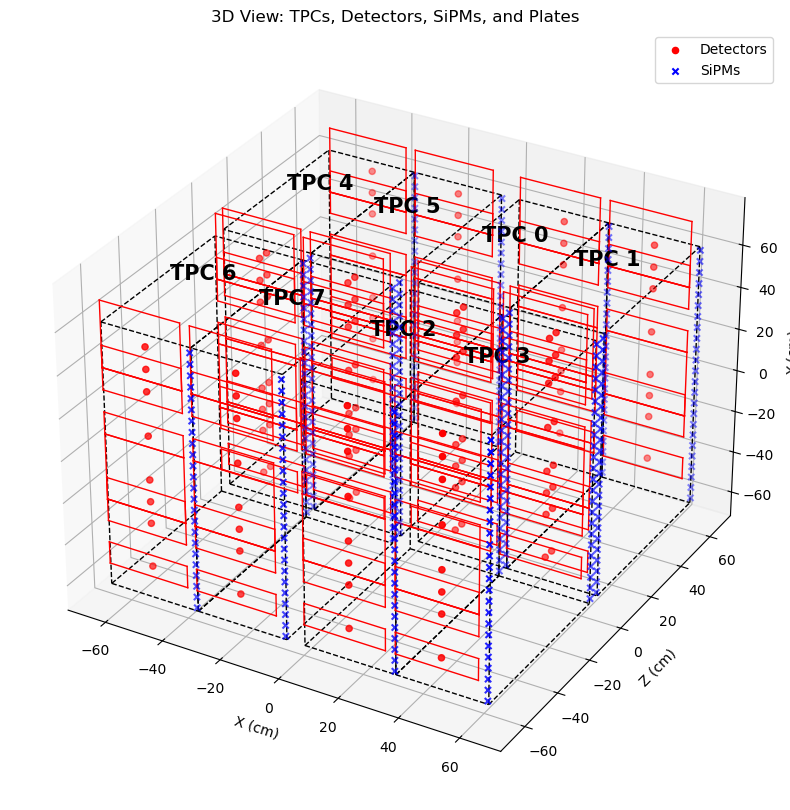

In [15]:
#This code cell defines the functions needed and then plots it for all detectors/sipms/TPCs, this looks very cluttered so another code cell plots it for a specified TPC
#TPC boundaries are within the actual data file so just pick an example data file and extract the stuff from this
def extract_tpc_bounds(file_obj):
    mod_bounds = np.array(file_obj['geometry_info'].attrs['module_RO_bounds']) 
    max_drift = file_obj['geometry_info'].attrs['max_drift_distance']
    tpc_bounds = []
    for mod in mod_bounds:
        x_min, y_min, z_min = mod[0]
        x_max, y_max, z_max = mod[1]
        #Two TPC boundaries per module:
        tpc_bounds.append(((x_max - max_drift, y_min, z_min), (x_max, y_max, z_max)))
        tpc_bounds.append(((x_min, y_min, z_min), (x_min + max_drift, y_max, z_max)))
    return np.array(tpc_bounds)


def flipYZ(coords):
#So standard ordering and plotting assumes X, Y, Z where Z is typically height, we want Y to be height so we sometimes need to flip the coords to make things look proper
    coords = np.array(coords)
    if coords.ndim == 1:
        #Flip a single point
        x, y, z = coords
        return np.array([x, z, y])
    else:
        #Flip an array
        return coords[:, [0,2,1]]

def draw_box(ax, bounds, **kwargs):
#Lets now draw the TPC boundary box 
    lower, upper = np.array(bounds[0]), np.array(bounds[1])
    x0, y0, z0 = lower  #(x_min, y_min, z_min)
    x1, y1, z1 = upper  #(x_max, y_max, z_max)

    #Need eight corners (probably a smarter way to do this)
    corners = np.array([
        [x0, y0, z0],  #Corner 0
        [x1, y0, z0],  #Corner 1
        [x1, y1, z0],  #Corner 2
        [x0, y1, z0],  #Corner 3
        [x0, y0, z1],  #Corner 4
        [x1, y0, z1],  #Corner 5
        [x1, y1, z1],  #Corner 6
        [x0, y1, z1]   #Corner 7
    ])

    edges = [
        (0,1), (1,2), (2,3), (3,0),  #bottom face
        (4,5), (5,6), (6,7), (7,4),  #top face
        (0,4), (1,5), (2,6), (3,7)   #vertical edges
    ]

    #Now flip the corners so that it matches the way were plotting the data in which the Y axis is the height
    corners = flipYZ(corners) 

    #Plot things
    for e in edges:
        p1, p2 = corners[e[0]], corners[e[1]]
        ax.plot(
            [p1[0], p2[0]],  #X
            [p1[1], p2[1]],  #Y in Matplotlib => real z
            [p1[2], p2[2]],  #Z in Matplotlib => real y
            **kwargs
        )

#We can load the detector center position and the SiPM position from the geometry 
#with open('/global/cfs/cdirs/dune/users/kunzmann/FSD/flow_james/ndlar_flow/data/proto_nd_flow/light_module_desc-5.0.1.yaml', 'r') as geom: #changed to 5.0.1, still works
 #   geom_data = yaml.safe_load(geom)

with open('/global/homes/m/mnuland/backtracking/light_module_desc-5.0.0.yaml', 'r') as geom: #changed to 5.0.1, still works
    geom_data = yaml.safe_load(geom)

det_positions_list = []
for det_id in sorted(geom_data['det_center'].keys()):
    x, y, z = geom_data['det_center'][det_id]
    det_positions_list.append([x, y, z])
det_positions = np.array(det_positions_list)
print("det_positions shape:", det_positions.shape)

sipm_positions_list = []
for sipm_id in sorted(geom_data['sipm_center'].keys()):
    x, y, z = geom_data['sipm_center'][sipm_id]
    sipm_positions_list.append([x, y, z])
sipm_positions = np.array(sipm_positions_list)
print("sipm_positions shape:", sipm_positions.shape)

#Take an example hdf5 file to extract the tpc bounds from
sample_hdf5_file = "/global/cfs/cdirs/dune/www/data/2x2/sandbox/v11/flow/packet-0050017-2024_07_09_01_14_40_CDT.FLOW.hdf5"
with h5flow.data.H5FlowDataManager(sample_hdf5_file, "r") as file_obj:
    tpc_bounds = extract_tpc_bounds(file_obj)  

#Build TPC labels
num_modules = len(tpc_bounds) // 2
tpc_labels = []
for i in range(num_modules):
    tpc_labels.append(f"TPC {2*i+1}")
    tpc_labels.append(f"TPC {2*i}")

#andddd make the plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

#Draw each TPC box and label
for i, bounds in enumerate(tpc_bounds):
    draw_box(ax, bounds, color='black', linestyle='--', linewidth=1)

    (x0, y0, z0), (x1, y1, z1) = bounds
    center_x = 0.5*(x0 + x1)
    center_y = y1 + 5.0   #place label above the tpc boundaries so it doesnt look too ugly
    center_z = 0.5*(z0 + z1)
    cx, cy, cz = flipYZ([center_x, center_y, center_z])
    ax.text(cx, cy, cz, tpc_labels[i], color='black', fontsize=15, fontweight='bold', ha='center')

#Draw these detector and SiPM positions (make sure to do this YZ flip)
det_positions_all = np.vstack([det_positions + np.mean(b, axis=0) for b in tpc_bounds])
sipm_positions_all = np.vstack([sipm_positions + np.mean(b, axis=0) for b in tpc_bounds])

ax.scatter(*flipYZ(det_positions_all).T, color='red', marker='o', label='Detectors')
ax.scatter(*flipYZ(sipm_positions_all).T, color='blue', marker='x', label='SiPMs')

#Lets focus on drawing these detector plates
#Function which takes as input the corners and draws this rectangle
def draw_plate_outline(ax, corners, **kwargs):
    seq = [0,1,2,3,0]
    for i in range(4):
        p1, p2 = corners[seq[i]], corners[seq[i+1]]
        ax.plot(*zip(p1, p2), **kwargs)

#Function to extract the plate corners from the geom file
def get_plate_corners(det_id, tpc_shift, geom_dict):
    shape_key = 0 if (det_id % 4) == 3 else 1 #Didnt have a better plan, but we know ACLs are every modulo 4 
    offs_min  = np.array(geom_dict['geom'][shape_key]['min'], float)
    offs_max  = np.array(geom_dict['geom'][shape_key]['max'], float)

    xmin,ymin,_ = offs_min
    xmax,ymax,_ = offs_max
    local_rect  = np.array([[xmin,ymin,0],[xmax,ymin,0],
                            [xmax,ymax,0],[xmin,ymax,0]])

    det_ctr_local = np.array(geom_dict['det_center'][det_id], float)
    return local_rect + det_ctr_local + tpc_shift

for tpc_idx, tpc_bounds_i in enumerate(tpc_bounds):
    tpc_shift = np.mean(tpc_bounds_i, axis=0)
    for det_id in sorted(geom_data['det_center'].keys(), key=int):
        plate_corners = get_plate_corners(int(det_id), tpc_shift, geom_data)
        draw_plate_outline(ax, flipYZ(plate_corners), color='red', linewidth=1)

#Show full detector and label the axes correctly
ax.set_xlabel("X (cm)")
ax.set_ylabel("Z (cm)")
ax.set_zlabel("Y (cm)")
#ax.set_xlim(-80, 80)
#ax.set_ylim(-80, 80)
#ax.set_zlim(-80, 80)
ax.set_title("3D View: TPCs, Detectors, SiPMs, and Plates")
ax.legend()
plt.show()

det_positions_local = det_positions

In [16]:
#print(geom_data.keys())
#print(geom_data['det_adc'])
print(geom_data['det_chan'])
#print(geom_data['det_side'])

{0: {0: [4, 5, 6, 7, 8, 9], 1: [4, 5], 2: [6, 7], 3: [8, 9], 4: [10, 11, 12, 13, 14, 15], 5: [10, 11], 6: [12, 13], 7: [14, 15], 8: [20, 21, 22, 23, 24, 25], 9: [20, 21], 10: [22, 23], 11: [24, 25], 12: [26, 27, 28, 29, 30, 31], 13: [26, 27], 14: [28, 29], 15: [30, 31]}, 1: {0: [52, 53, 54, 55, 56, 57], 1: [52, 53], 2: [54, 55], 3: [56, 57], 4: [58, 59, 60, 61, 62, 63], 5: [58, 59], 6: [60, 61], 7: [62, 63], 8: [36, 37, 38, 39, 40, 41], 9: [36, 37], 10: [38, 39], 11: [40, 41], 12: [42, 43, 44, 45, 46, 47], 13: [42, 43], 14: [44, 45], 15: [46, 47]}, 2: {0: [4, 5, 6, 7, 8, 9], 1: [20, 21], 2: [22, 23], 3: [24, 25], 4: [10, 11, 12, 13, 14, 15], 5: [26, 27], 6: [28, 29], 7: [30, 31], 8: [20, 21, 22, 23, 24, 25], 9: [4, 5], 10: [6, 7], 11: [8, 9], 12: [26, 27, 28, 29, 30, 31], 13: [10, 11], 14: [12, 13], 15: [14, 15]}, 3: {0: [52, 53, 54, 55, 56, 57], 1: [52, 53], 2: [54, 55], 3: [56, 57], 4: [58, 59, 60, 61, 62, 63], 5: [58, 59], 6: [60, 61], 7: [62, 63], 8: [36, 37, 38, 39, 40, 41], 9: [3

In [17]:
f["charge"].keys()

<KeysViewHDF5 ['calib_final_hits', 'calib_prompt_hits', 'events', 'ext_trigs', 'packets', 'packets_corr_ts', 'pps_delay', 'raw_events', 'raw_hits']>

### 2.4 dbscan & ransac algorithms

In [18]:
# Assumes: file is open, geom_data is loaded, tpc_bounds are extracted
# dbscan function before linear fit
# det_positions_local = det_positions

def select_main_dbscan_cluster(x, y, z, dE, eps=2.0, min_samples=3):
    """
    Run DBSCAN on (x,y,z) and keep only the largest non-noise cluster.
    If clustering fails or everything is noise, return the original arrays.

    Parameters
    ----------
    x, y, z : 1D arrays
        Hit positions.
    dE : 1D array
        Energy deposit per hit (aligned with x,y,z).
    eps : float
        DBSCAN eps (distance scale, in same units as x,y,z, e.g. cm).
    min_samples : int
        Minimum number of points to form a cluster.

    Returns
    -------
    x_f, y_f, z_f, dE_f : 1D arrays
        Filtered arrays containing only the main cluster (or original if clustering fails).
    """
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    dE = np.asarray(dE)

    # not enough points to cluster → just return
    if len(x) < min_samples:
        return x, y, z, dE

    coords = np.column_stack((x, y, z))

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(coords)

    # labels == -1 are noise
    unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)

    if len(unique_labels) == 0:
        # everything is noise → fall back to original hits
        print("DBSCAN: all hits classified as noise, using all hits.")
        return x, y, z, dE

    # pick the label of the largest cluster
    main_label = unique_labels[np.argmax(counts)]

    main_mask = (labels == main_label)

    x_f = x[main_mask]
    y_f = y[main_mask]
    z_f = z[main_mask]
    dE_f = dE[main_mask]

    print(f"DBSCAN: selected main cluster label {main_label} with {np.sum(main_mask)} hits "
          f"out of {len(x)} total hits.")

    return x_f, y_f, z_f, dE_f

#new process tpc with dbscan    
def process_tpc(tpc_idx, file, event, tpc_bounds, geom_data, ax=None):
    print(f"\nProcessing TPC {tpc_idx}")
    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # --- Get muon hits ---
    my_muon_hits = file['charge/events', 'charge/calib_prompt_hits', event]

    x = my_muon_hits['x'].reshape(-1)
    y = my_muon_hits['y'].reshape(-1)
    z = my_muon_hits['z'].reshape(-1)
    dE = my_muon_hits['E'].reshape(-1)

    # restrict to this TPC volume
    mask = (
        (x >= lower[0]) & (x <= upper[0]) &
        (y >= lower[1]) & (y <= upper[1]) &
        (z >= lower[2]) & (z <= upper[2])
    )
    hits_x, hits_y, hits_z, hits_dE = x[mask], y[mask], z[mask], dE[mask]

    print(f"  Hits in TPC (before clustering): {len(hits_x)}")

    # --- NEW: apply DBSCAN clustering on hits within this TPC ---
    hits_x, hits_y, hits_z, hits_dE = select_main_dbscan_cluster(
        hits_x, hits_y, hits_z, hits_dE,
        eps=5.0,        # tune if needed
        min_samples=5   # tune if needed
    )

    print(f"  Hits in TPC (after clustering): {len(hits_x)}")

    if len(hits_x) < 2:
        print("  Not enough hits after DBSCAN to perform line fit; skipping this TPC.")
        return []

    #Select the TPC to visualize
    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    #Draw detector plates (rectangles only numerically here)
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0, y0, z0), (x1, y1, z1) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0, z1]
    # I'm going to need a tolerance to find the 8 unique ones
    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, unique_det, atol=tolerance) for unique_det in unique_dets):
            unique_dets.append(det)

    # Now the line fit (inside compute_light_fraction_w_liner_fit) sees only the main cluster
    results = plot_light_on_detectors(hits_x, hits_y, hits_z, hits_dE, unique_dets, my_detector_z, ax=ax)

    return results


In [19]:
# v1 - Include dbscan and ransac, else fall back to original line fit
def process_tpc_from_line(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # keep only segments whose midpoints fall inside this TPC volume
    mask_tpc = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    if not np.any(mask_tpc):
        print("  No line segments inside this TPC; expected light = 0.")
        return []

    x_t = x_mid[mask_tpc]
    y_t = y_mid[mask_tpc]
    z_t = z_mid[mask_tpc]
    L_t = step_length[mask_tpc]

    # same plate geometry construction as in process_tpc
    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:
            det, prod, frac = compute_light_fraction_from_line_midpoints(
                x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
            )
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results

In [20]:
# v2- check new process, where the non-irradiated TPCs also get processed even if no hits are in them
def process_tpc_from_line(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # keep only segments whose midpoints fall inside this TPC volume
    mask_tpc = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    if not np.any(mask_tpc):
        print("  No line segments inside this TPC; expected light = 0.")
        # use empty arrays so compute_light_fraction_from_line_midpoints
        # returns (0, 0, 0) for every rectangle
        x_t = np.array([])
        y_t = np.array([])
        z_t = np.array([])
        L_t = np.array([])
    else:
        x_t = x_mid[mask_tpc]
        y_t = y_mid[mask_tpc]
        z_t = z_mid[mask_tpc]
        L_t = step_length[mask_tpc]

    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:
            det, prod, frac = compute_light_fraction_from_line_midpoints(
                x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
            )
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [21]:
# v3.1 - keep |z|<49.99 cm, ineritly this is wrong since the borders of the FSD light traps are at approx 47.5cm
def process_tpc_from_line(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # geometry mask: segments inside this TPC volume
    mask_geom = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    # z-safety mask: avoid singularities near |z| ~ 50
    mask_zsafe = (z_mid > -49.99) & (z_mid < 49.99)

    # combined mask: in TPC AND in safe z-range
    mask_tpc = mask_geom & mask_zsafe

    if not np.any(mask_tpc):
        print("  No safe line segments inside this TPC; expected light = 0.")
        # empty arrays → compute_light_fraction_from_line_midpoints returns 0
        x_t = np.array([])
        y_t = np.array([])
        z_t = np.array([])
        L_t = np.array([])
    else:
        x_t = x_mid[mask_tpc]
        y_t = y_mid[mask_tpc]
        z_t = z_mid[mask_tpc]
        L_t = step_length[mask_tpc]

    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:
            det, prod, frac = compute_light_fraction_from_line_midpoints(
                x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
            )
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [22]:
# v3.2 - keep |z|<47.5 cm, adapted to the correct surface distance
def process_tpc_from_line(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # geometry mask: segments inside this TPC volume
    mask_geom = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    # z-safety mask: avoid singularities near |z| ~ 50
    mask_zsafe = (z_mid > -47.5) & (z_mid < 47.5)

    # combined mask: in TPC AND in safe z-range
    mask_tpc = mask_geom & mask_zsafe

    if not np.any(mask_tpc):
        print("  No safe line segments inside this TPC; expected light = 0.")
        # empty arrays → compute_light_fraction_from_line_midpoints returns 0
        x_t = np.array([])
        y_t = np.array([])
        z_t = np.array([])
        L_t = np.array([])
    else:
        x_t = x_mid[mask_tpc]
        y_t = y_mid[mask_tpc]
        z_t = z_mid[mask_tpc]
        L_t = step_length[mask_tpc]

    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:
            det, prod, frac = compute_light_fraction_from_line_midpoints(
                x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
            )
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [23]:
print(p_events)

[153, 554, 562, 596, 628, 666, 788, 815, 882, 909, 924, 1015, 1026, 1059, 1081, 1090, 1274, 1326, 1360, 1369, 1418, 1485, 1491, 1649, 1656, 1672, 1688, 1766, 2006, 2052, 2079, 2300, 2345, 2419, 3549, 3824, 3851, 3853, 3921, 3944, 4031, 4125, 4341, 4477, 4524, 4776, 4843, 4873, 4917, 5034, 5098, 5320, 5383, 6112, 6138, 6620, 8050, 8231, 8463, 8485, 8508, 8563, 8567, 8624, 8692, 8761, 8811, 8872, 8873, 8875, 8928, 9023, 9084, 9124]


In [24]:
def ransac_line_3d(x, y, z,
                   distance_threshold=1.0,
                   min_inliers=10,
                   max_trials=1000,
                   random_state=None):
    """
    Robustly fit a 3D line (infinite) using a simple RANSAC scheme.

    Returns
    -------
    centroid : (3,) array
        Point on the best-fit line (center of inliers).
    direction : (3,) array
        Unit direction vector of the line.
    inlier_mask : (N,) bool array
        True for hits considered inliers of the final model.
    """
    rng = np.random.default_rng(random_state)
    pts = np.column_stack((x, y, z))
    N = pts.shape[0]

    if N < 2:
        raise ValueError("Not enough points for RANSAC line fit")

    best_inliers = None
    best_count = 0

    for _ in range(max_trials):
        # random pair of distinct points
        i1, i2 = rng.choice(N, size=2, replace=False)
        p0 = pts[i1]
        p1 = pts[i2]
        v = p1 - p0
        norm = np.linalg.norm(v)
        if norm == 0:
            continue
        v /= norm

        # distance of all points to this line
        diff = pts - p0
        proj = diff @ v
        closest = np.outer(proj, v)
        dist = np.linalg.norm(diff - closest, axis=1)

        inliers = dist < distance_threshold
        count = np.count_nonzero(inliers)

        if count > best_count:
            best_count = count
            best_inliers = inliers

            # early break if almost everything is an inlier
            if best_count >= max(min_inliers, 0.9 * N):
                break

    # if RANSAC failed badly, fall back to all points
    if best_inliers is None or best_count < max(2, min_inliers):
        best_inliers = np.ones(N, dtype=bool)

    inlier_pts = pts[best_inliers]
    centroid = inlier_pts.mean(axis=0)
    _, _, vt = np.linalg.svd(inlier_pts - centroid)
    direction = vt[0]
    direction /= np.linalg.norm(direction)

    return centroid, direction, best_inliers


def line_midpoints_from_model(centroid, direction, pts, seg_length):
    """
    Given a line model (centroid + direction) and a cloud of points,
    build equally spaced segment midpoints along the line
    that spans those points.

    Returns
    -------
    x_mid, y_mid, z_mid, step_len
    """
    diff = pts - centroid
    t = diff @ direction
    t_min, t_max = t.min(), t.max()

    t_edges = np.arange(t_min, t_max, seg_length)
    if t_edges[-1] < t_max:
        t_edges = np.append(t_edges, t_max)

    t_mid = 0.5 * (t_edges[:-1] + t_edges[1:])
    step_len = np.diff(t_edges)

    mid = centroid + np.outer(t_mid, direction)
    x_mid, y_mid, z_mid = mid[:, 0], mid[:, 1], mid[:, 2]

    return x_mid, y_mid, z_mid, step_len


## 3 Calling the functions and plotting

### 3.1 dbscan & ransac plots

In [25]:
print(p_events)

[153, 554, 562, 596, 628, 666, 788, 815, 882, 909, 924, 1015, 1026, 1059, 1081, 1090, 1274, 1326, 1360, 1369, 1418, 1485, 1491, 1649, 1656, 1672, 1688, 1766, 2006, 2052, 2079, 2300, 2345, 2419, 3549, 3824, 3851, 3853, 3921, 3944, 4031, 4125, 4341, 4477, 4524, 4776, 4843, 4873, 4917, 5034, 5098, 5320, 5383, 6112, 6138, 6620, 8050, 8231, 8463, 8485, 8508, 8563, 8567, 8624, 8692, 8761, 8811, 8872, 8873, 8875, 8928, 9023, 9084, 9124]


In [26]:
event=500
event=44
event=1289
event = 9045
# problematic events: 7493, 69528
# very nice ones 97, 17359

# Create cluster filtered light signal and 

my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

coords = np.column_stack((x, y, z))

# ---------------------------------
# Global DBSCAN: keep only largest cluster
# ---------------------------------
db = DBSCAN(eps=5.0, min_samples=3)
labels = db.fit_predict(coords)

mask_non_noise = labels != -1
if np.any(mask_non_noise):
    labels_nn = labels[mask_non_noise]
    uniq, counts = np.unique(labels_nn, return_counts=True)
    main_label = uniq[np.argmax(counts)]
    cluster_mask = labels == main_label
    print(f"Event {event}: main cluster label {{main_label}}, size {{np.sum(cluster_mask)}}")
else:
    cluster_mask = np.zeros_like(labels, dtype=bool)
    print(f"Event {event}: no non-noise clusters, falling back to all hits.")

# ---------------------------------
# RANSAC line on the main cluster
# ---------------------------------
if np.sum(cluster_mask) >= 2:
    x_c = x[cluster_mask]
    y_c = y[cluster_mask]
    z_c = z[cluster_mask]

    centroid, direction, inliers_r = ransac_line_3d(
        x_c, y_c, z_c,
        distance_threshold=1.0,
        min_inliers=5,
        max_trials=500,
        random_state=42
    )

    pts_c = np.column_stack((x_c, y_c, z_c))
    seg_length = 0.1  # cm
    x_mid, y_mid, z_mid, step_length = line_midpoints_from_model(
        centroid, direction, pts_c, seg_length
    )

    # After calling line_midpoints_from_model(...)
    num_midpoints = len(x_mid)
    track_length = np.sum(step_length)

    print("----- RANSAC Track Summary -----")
    print(f"Segment length (cm):         {seg_length}")
    print(f"Total track length (cm):     {track_length:.2f}")
    print(f"Number of midpoints:         {num_midpoints}")
    print(f"Approx expected midpoints:   {track_length / seg_length:.2f}")
    print("---------------------------------")


    print(f"Event {event}: RANSAC inliers {{np.sum(inliers_r)}} / {{len(x_c)}} in cluster")
else:
    print(f"Event {event}: not enough clustered hits for RANSAC; using PCA line fit.")
    seg_length = 0.1
    x_mid, y_mid, z_mid, step_length = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# ---------------------------------
# Use the global line to compute light TPC-by-TPC
# ---------------------------------
all_results = []

for tpc_idx in range(len(tpc_bounds)):
    results = process_tpc_from_line(
        tpc_idx,
        x_mid, y_mid, z_mid, step_length,
        tpc_bounds, geom_data
    )
    all_results.extend(results)

Event 9045: main cluster label {main_label}, size {np.sum(cluster_mask)}
----- RANSAC Track Summary -----
Segment length (cm):         0.1
Total track length (cm):     1.50
Number of midpoints:         15
Approx expected midpoints:   14.99
---------------------------------
Event 9045: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 2 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 3 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 4 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 5 from global line

Processing TPC 6 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 7 from global line
  No safe

In [27]:
# ------------------------------------------
# 1) Compute detector colors from all_results
# ------------------------------------------
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

total_produced = np.sum(produced_all)
colors_norm = detected_all / total_produced

# Normalize to [0, 1]
colors_norm = (colors_norm - np.min(colors_norm)) / (np.max(colors_norm) - np.min(colors_norm))

cmap = cm.get_cmap("inferno")

xs_det, ys_det, zs_det = [], [], []
i_idx, j_idx, k_idx = [], [], []
intensity = []

for idx, (result, cnorm) in enumerate(zip(all_results, colors_norm)):
    x0, y0, x1, y1, z_det, *_ = result

    base = len(xs_det)

    # Same coordinate convention as before: (X, Z, Y) -> (x, y, z) for Plotly
    xs_det.extend([x0, x1, x1, x0])
    ys_det.extend([z_det, z_det, z_det, z_det])
    zs_det.extend([y0, y0, y1, y1])

    i_idx.extend([base, base])
    j_idx.extend([base + 1, base + 2])
    k_idx.extend([base + 2, base + 3])

    intensity.extend([cnorm] * 4)

mesh_det = go.Mesh3d(
    x=xs_det,
    y=ys_det,
    z=zs_det,
    i=i_idx,
    j=j_idx,
    k=k_idx,
    intensity=intensity,
    colorscale='Inferno',
    showscale=True,

    colorbar=dict(
        title=dict(
            text='Light detected (normalized)',
            side='bottom'   # ← put the title under the vertical colorbar
        ),
        thickness=15,
        len=0.8,
    ),

    opacity=0.5,
    name='Light traps'
)


# ------------------------------------------
# 2) Global muon hits for this event
# ------------------------------------------
my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

coords = np.column_stack((x, y, z))

# ------------------------------------------
# 3) DBSCAN: keep ONLY the largest non-noise cluster
# ------------------------------------------
db = DBSCAN(eps=5.0, min_samples=3)
labels = db.fit_predict(coords)

mask_non_noise = labels != -1

if np.any(mask_non_noise):
    labels_nn = labels[mask_non_noise]
    uniq, counts = np.unique(labels_nn, return_counts=True)
    main_label = uniq[np.argmax(counts)]
    cluster_mask = labels == main_label
    print(f"DBSCAN: main cluster label {main_label}, size {np.sum(cluster_mask)}")
else:
    cluster_mask = np.zeros_like(labels, dtype=bool)
    print("DBSCAN: no non-noise clusters, everything is noise.")

noise_mask = ~cluster_mask

print(f"Total hits: {len(x)}")
print(f"Main-cluster hits: {np.sum(cluster_mask)}")
print(f"Noise/other hits: {np.sum(noise_mask)}")

# ------------------------------------------
# 4) RANSAC line fit
# ------------------------------------------
if np.sum(cluster_mask) >= 2:
    x_c = x[cluster_mask]
    y_c = y[cluster_mask]
    z_c = z[cluster_mask]

    centroid, direction, inliers_r = ransac_line_3d(
        x_c, y_c, z_c,
        distance_threshold=1.0,
        min_inliers=5,
        max_trials=500,
        random_state=42
    )

    print(f"RANSAC inliers: {np.sum(inliers_r)} out of {len(x_c)} in cluster")

    pts_c = np.column_stack((x_c, y_c, z_c))
    seg_length = 0.1  # cm
    x_mid, y_mid, z_mid, step_len = line_midpoints_from_model(
        centroid, direction, pts_c, seg_length
    )
else:
    print("Not enough clustered hits for RANSAC; falling back to SVD.")
    seg_length = 0.1
    x_mid, y_mid, z_mid, step_len = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# ------------------------------------------
# 5) Plotly traces
# ------------------------------------------

# Clustered hits
hits_cluster = go.Scatter3d(
    x=x[cluster_mask],
    y=z[cluster_mask],
    z=y[cluster_mask],
    mode='markers',
    marker=dict(size=3, color='cyan'),
    name='Main cluster hits'
)

# Noise
hits_noise = go.Scatter3d(
    x=x[noise_mask],
    y=z[noise_mask],
    z=y[noise_mask],
    mode='markers',
    marker=dict(size=3, color='black'),
    name='Noise / other clusters'
)

# RANSAC segment midpoints
fit_midpoints = go.Scatter3d(
    x=x_mid,
    y=z_mid,
    z=y_mid,
    mode='markers',
    marker=dict(size=4, color='magenta'),
    name='RANSAC midpoints'
)

fig = go.Figure(data=[mesh_det, hits_cluster, hits_noise, fit_midpoints])

# ------------------------------------------
# Layout (legend moved to the right!)
# ------------------------------------------
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Z',
        zaxis_title='Y',
        xaxis=dict(range=[-50, 50]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[-150, 150]),
    ),
    title=f'Expected light + muon track + DBSCAN + RANSAC (event {event})',
    width=900,
    height=800,

    legend=dict(
        x=1.05,  # move legend outside the right boundary
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.6)'
    )
)

fig.show()


/tmp/ipykernel_257718/3747413649.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("inferno")


DBSCAN: main cluster label 0, size 7
Total hits: 13
Main-cluster hits: 7
Noise/other hits: 6
RANSAC inliers: 7 out of 7 in cluster


### 3.2 old linear fit and light generation

In [28]:
all_results = []

for tpc_idx in range(len(tpc_bounds)):
    results = process_tpc(tpc_idx, f, event, tpc_bounds, geom_data, ax=None)
    all_results.extend(results)  # Flatten everything into one big list

# Compute total detected and produced light across all detectors
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

# ------------------------------------------
# 1) Compute detector colors from all_results (same as before)
# ------------------------------------------
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

total_produced = np.sum(produced_all)
colors_norm = detected_all / total_produced

# Normalize to [0, 1]  (same formula as in Matplotlib code)
colors_norm = (colors_norm - np.min(colors_norm)) / (np.max(colors_norm) - np.min(colors_norm))

cmap = cm.get_cmap("inferno")

xs_det, ys_det, zs_det = [], [], []
i_idx, j_idx, k_idx = [], [], []
intensity = []

for idx, (result, cnorm) in enumerate(zip(all_results, colors_norm)):
    x0, y0, x1, y1, z_det, *_ = result

    base = len(xs_det)

    # Same coordinate convention as in Matplotlib: (X, Z, Y)
    xs_det.extend([x0, x1, x1, x0])
    ys_det.extend([z_det, z_det, z_det, z_det])
    zs_det.extend([y0, y0, y1, y1])

    i_idx.extend([base, base])
    j_idx.extend([base + 1, base + 2])
    k_idx.extend([base + 2, base + 3])

    intensity.extend([cnorm] * 4)

mesh_det = go.Mesh3d(
    x=xs_det,
    y=ys_det,
    z=zs_det,
    i=i_idx,
    j=j_idx,
    k=k_idx,
    intensity=intensity,
    colorscale='Inferno',
    showscale=True,

    colorbar=dict(
        title=dict(
            text='Light detected (globally normalized)',
            side='bottom'   # put the title under the vertical colorbar
        ),
        thickness=15,
        len=0.8,
    ),

    opacity=0.5,
    name='Light traps'
)

# ------------------------------------------
# 2) Muon track hits (same as Matplotlib)
# ------------------------------------------
my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

# Scatter of all muon hits (blue), same axis mapping X, Z, Y
hits_track = go.Scatter3d(
    x=x,
    y=z,
    z=y,
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='Muon track'
)

# ------------------------------------------
# 3) Fit midpoints from line_fit_3d_segment_midpoints (same content)
# ------------------------------------------
seg_length = 0.1  # cm, as in your Matplotlib code

x_mid, y_mid, z_mid, step_len = line_fit_3d_segment_midpoints(x, y, z, seg_length)

fit_midpoints = go.Scatter3d(
    x=x_mid,
    y=z_mid,
    z=y_mid,
    mode='markers',
    marker=dict(size=4, color='cyan'),
    name='Fit midpoints'
)

# ------------------------------------------
# 4) Build figure
# ------------------------------------------
fig = go.Figure(data=[mesh_det, hits_track, fit_midpoints])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Z',
        zaxis_title='Y',
        xaxis=dict(range=[-50, 50]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[-150, 150]),
    ),
    title=f'Expected light on all light traps based on muon track, event number {event}',
    width=900,
    height=800,

    legend=dict(
        x=1.05,  # move legend outside the right boundary
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.6)'
    )
)

fig.show()



Processing TPC 0
  Hits in TPC (before clustering): 0
  Hits in TPC (after clustering): 0
  Not enough hits after DBSCAN to perform line fit; skipping this TPC.

Processing TPC 1
  Hits in TPC (before clustering): 1
  Hits in TPC (after clustering): 1
  Not enough hits after DBSCAN to perform line fit; skipping this TPC.

Processing TPC 2
  Hits in TPC (before clustering): 0
  Hits in TPC (after clustering): 0
  Not enough hits after DBSCAN to perform line fit; skipping this TPC.

Processing TPC 3
  Hits in TPC (before clustering): 0
  Hits in TPC (after clustering): 0
  Not enough hits after DBSCAN to perform line fit; skipping this TPC.

Processing TPC 4
  Hits in TPC (before clustering): 1
  Hits in TPC (after clustering): 1
  Not enough hits after DBSCAN to perform line fit; skipping this TPC.

Processing TPC 5
  Hits in TPC (before clustering): 8
DBSCAN: selected main cluster label 0 with 7 hits out of 8 total hits.
  Hits in TPC (after clustering): 7

Processing TPC 6
  Hits in 

/tmp/ipykernel_257718/1544814593.py:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Processing TPC 0
  Hits in TPC (before clustering): 211
DBSCAN: selected main cluster label 0 with 210 hits out of 211 total hits.
  Hits in TPC (after clustering): 210



Processing TPC 1
  Hits in TPC (before clustering): 2
  Hits in TPC (after clustering): 2


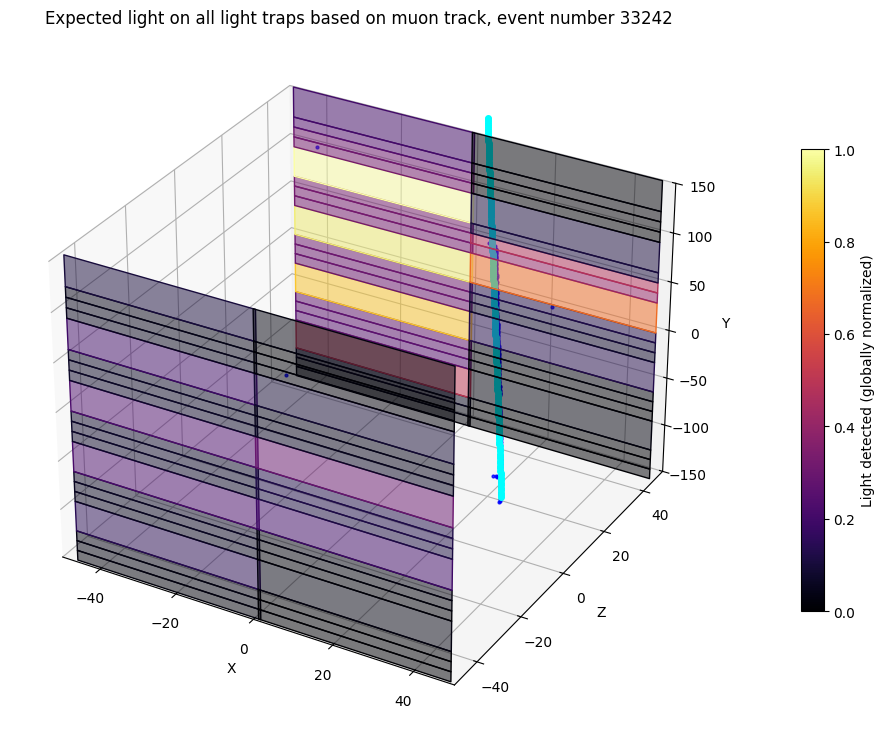

In [ ]:
##add the linear fit middle points

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

all_results = []

for tpc_idx in range(len(tpc_bounds)):
    results = process_tpc(tpc_idx, f, event, tpc_bounds, geom_data, ax=None)
    all_results.extend(results)  # Flatten everything into one big list

# Compute total detected and produced light across all detectors
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

total_produced = np.sum(produced_all)
colors_norm = detected_all / total_produced

# Normalize to [0, 1]
colors_norm = (colors_norm - np.min(colors_norm)) / (np.max(colors_norm) - np.min(colors_norm))

# Colormap
cmap = plt.cm.inferno
colors = cmap(colors_norm)

# Plot detectors with global-normalized color
for result, color in zip(all_results, colors):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    rect = Poly3DCollection([corners], color=color, alpha=0.5)
    ax.add_collection3d(rect)

# Plot muon track
my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event] #anpassen file für 

#all of the following is the same as above muon_hits:
#hits_dset = 'calib_prompt_hits'
#hits_full = f['charge/'+hits_dset+'/data']
#hits_ref = f['charge/events/ref/charge/'+hits_dset+'/ref']
#hits_region = f['charge/events/ref/charge/'+hits_dset+'/ref_region']
#hit_ref = hits_ref[hits_region[event,'start']:hits_region[event,'stop']]
#hit_ref = np.sort(hit_ref[hit_ref[:,0] == event, 1])
#my_muon_hits = hits_full[hit_ref]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)
ax.plot(x, z, y, color='b', marker='o', markersize=2, ls='none', alpha=0.8, label='Muon track')



# --------------------------------------------------
# Compute segment midpoints from your fit function
# --------------------------------------------------
seg_length = 0.1 #cm   # choose whatever step length you want

x_mid, y_mid, z_mid, step_len = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# Plot the segment midpoints (same axis order X, Z, Y)
ax.plot(x_mid, z_mid, y_mid,
        marker='o',
        ls='none',
        markersize=4,
        color='cyan',
        label='Fit midpoints')


# Colorbar
sm = ScalarMappable(cmap=cmap)
sm.set_array(colors_norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Light detected (globally normalized)')

# Axis labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-150, 150)
ax.set_title('Expected light on all light traps based on muon track, event number '+str(event))
plt.show()


### 3.3 Test crossing leaving out

In [29]:
# v4 - leave traps where tracks cross
def process_tpc_from_line_LTcrossing(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data,
                          z_safe=47.5,
                          z_cross_tol=0.5):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Additional behavior:
      - Only uses segments with |z| < z_safe (to avoid solid-angle singularity).
      - For any light trap that the track crosses (i.e. a midpoint lies inside
        the trap's x/y footprint and within z_cross_tol of z_det), the expected
        light is set to NaN so that it can be excluded in later PDE analysis.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
        where det, prod, frac may be NaN for traps traversed by the track.
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # Geometry mask: segments inside this TPC volume
    mask_geom = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    # z-safety mask: avoid singularities near |z| ~ detector planes
    mask_zsafe = (z_mid > -z_safe) & (z_mid < z_safe)

    # Combined mask: in this TPC AND in safe z range
    mask_tpc = mask_geom & mask_zsafe

    if not np.any(mask_tpc):
        print("  No safe line segments inside this TPC; expected light = 0.")
        # empty arrays → compute_light_fraction_from_line_midpoints returns 0
        x_t = np.array([])
        y_t = np.array([])
        z_t = np.array([])
        L_t = np.array([])
    else:
        x_t = x_mid[mask_tpc]
        y_t = y_mid[mask_tpc]
        z_t = z_mid[mask_tpc]
        L_t = step_length[mask_tpc]

    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    # Build detector rectangles in this TPC
    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)  # (x,y,z)
        cf = flipYZ(corners)  # -> (x,z,y)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))  # (x0,y0,x1,y1)

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    # Remove duplicates (within tolerance)
    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []

    # For each detector plane and rectangle, compute expected light
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:

            # --- NEW: check if the track crosses this light trap ---
            # A crossing is approximated by having at least one
            # segment midpoint inside the x/y footprint and close to z_det.
            crosses_mask = (
                (x_t >= x0) & (x_t <= x1) &
                (y_t >= y0) & (y_t <= y1) &
                (np.abs(z_t - z_det) <= z_cross_tol)
            )

            if np.any(crosses_mask):
                # Mark this trap as "contaminated" by Cherenkov: ignore in PDE
                det = np.nan
                prod = np.nan
                frac = np.nan
                # Optional debug:
                # print(f"  TPC {tpc_idx}: trap ({x0},{y0})-({x1},{y1}) at z={z_det} crossed by track, skipping.")
            else:
                # Normal scintillation expectation
                det, prod, frac = compute_light_fraction_from_line_midpoints(
                    x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
                )

            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [30]:
print(p_events)

[153, 554, 562, 596, 628, 666, 788, 815, 882, 909, 924, 1015, 1026, 1059, 1081, 1090, 1274, 1326, 1360, 1369, 1418, 1485, 1491, 1649, 1656, 1672, 1688, 1766, 2006, 2052, 2079, 2300, 2345, 2419, 3549, 3824, 3851, 3853, 3921, 3944, 4031, 4125, 4341, 4477, 4524, 4776, 4843, 4873, 4917, 5034, 5098, 5320, 5383, 6112, 6138, 6620, 8050, 8231, 8463, 8485, 8508, 8563, 8567, 8624, 8692, 8761, 8811, 8872, 8873, 8875, 8928, 9023, 9084, 9124]


In [31]:
# v4 plots: change 

event=500
event=44
event=1289
event = 9045
# problematic events: 7493, 69528
# very nice ones 97, 17359

# Create cluster filtered light signal and 

my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

coords = np.column_stack((x, y, z))

# ---------------------------------
# Global DBSCAN: keep only largest cluster
# ---------------------------------
db = DBSCAN(eps=5.0, min_samples=3)
labels = db.fit_predict(coords)

mask_non_noise = labels != -1
if np.any(mask_non_noise):
    labels_nn = labels[mask_non_noise]
    uniq, counts = np.unique(labels_nn, return_counts=True)
    main_label = uniq[np.argmax(counts)]
    cluster_mask = labels == main_label
    print(f"Event {event}: main cluster label {{main_label}}, size {{np.sum(cluster_mask)}}")
else:
    cluster_mask = np.zeros_like(labels, dtype=bool)
    print(f"Event {event}: no non-noise clusters, falling back to all hits.")

# ---------------------------------
# RANSAC line on the main cluster
# ---------------------------------
if np.sum(cluster_mask) >= 2:
    x_c = x[cluster_mask]
    y_c = y[cluster_mask]
    z_c = z[cluster_mask]

    centroid, direction, inliers_r = ransac_line_3d(
        x_c, y_c, z_c,
        distance_threshold=1.0,
        min_inliers=5,
        max_trials=500,
        random_state=42
    )

    pts_c = np.column_stack((x_c, y_c, z_c))
    seg_length = 0.1  # cm
    x_mid, y_mid, z_mid, step_length = line_midpoints_from_model(
        centroid, direction, pts_c, seg_length
    )

    # After calling line_midpoints_from_model(...)
    num_midpoints = len(x_mid)
    track_length = np.sum(step_length)

    # print("----- RANSAC Track Summary -----")
    # print(f"Segment length (cm):         {seg_length}")
    # print(f"Total track length (cm):     {track_length:.2f}")
    # print(f"Number of midpoints:         {num_midpoints}")
    # print(f"Approx expected midpoints:   {track_length / seg_length:.2f}")
    # print("---------------------------------")


    print(f"Event {event}: RANSAC inliers {{np.sum(inliers_r)}} / {{len(x_c)}} in cluster")
else:
    print(f"Event {event}: not enough clustered hits for RANSAC; using PCA line fit.")
    seg_length = 0.1
    x_mid, y_mid, z_mid, step_length = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# ---------------------------------
# Use the global line to compute light TPC-by-TPC
# ---------------------------------
all_results = []

for tpc_idx in range(len(tpc_bounds)):
    results = process_tpc_from_line_LTcrossing(
        tpc_idx,
        x_mid, y_mid, z_mid, step_length,
        tpc_bounds, geom_data
    )
    all_results.extend(results)

# ------------------------------------------
# 1) Compute detector colors from all_results
# ------------------------------------------
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

# For plotting, treat NaNs as 0 expected light
det_safe = np.nan_to_num(detected_all, nan=0.0, posinf=0.0, neginf=0.0)
prod_safe = np.nan_to_num(produced_all, nan=0.0, posinf=0.0, neginf=0.0)

total_produced = np.sum(prod_safe)
if total_produced <= 0:
    colors_raw = np.zeros_like(det_safe)
else:
    colors_raw = det_safe / total_produced

# Normalize to [0, 1], ignoring any non-finite values just in case
finite_mask = np.isfinite(colors_raw)
if np.any(finite_mask):
    cmin = np.min(colors_raw[finite_mask])
    cmax = np.max(colors_raw[finite_mask])
    if cmax == cmin:
        colors_norm = np.zeros_like(colors_raw)
    else:
        colors_norm = (colors_raw - cmin) / (cmax - cmin)
else:
    colors_norm = np.zeros_like(colors_raw)

cmap = cm.get_cmap("inferno")

xs_det, ys_det, zs_det = [], [], []
i_idx, j_idx, k_idx = [], [], []
intensity = []

for idx, (result, cnorm) in enumerate(zip(all_results, colors_norm)):
    x0, y0, x1, y1, z_det, *_ = result

    base = len(xs_det)

    # Same coordinate convention as before: (X, Z, Y) -> (x, y, z) for Plotly
    xs_det.extend([x0, x1, x1, x0])
    ys_det.extend([z_det, z_det, z_det, z_det])
    zs_det.extend([y0, y0, y1, y1])

    i_idx.extend([base, base])
    j_idx.extend([base + 1, base + 2])
    k_idx.extend([base + 2, base + 3])

    intensity.extend([cnorm] * 4)

mesh_det = go.Mesh3d(
    x=xs_det,
    y=ys_det,
    z=zs_det,
    i=i_idx,
    j=j_idx,
    k=k_idx,
    intensity=intensity,
    colorscale='Inferno',
    showscale=True,
    colorbar=dict(
        title=dict(
            text='Light detected (normalized)',
            side='bottom'
        ),
        thickness=15,
        len=0.8,
    ),
    opacity=0.5,
    name='Light traps'
)


# ------------------------------------------
# 2) Global muon hits for this event
# ------------------------------------------
my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

coords = np.column_stack((x, y, z))

# ------------------------------------------
# 3) DBSCAN: keep ONLY the largest non-noise cluster
# ------------------------------------------
db = DBSCAN(eps=5.0, min_samples=3)
labels = db.fit_predict(coords)

mask_non_noise = labels != -1

if np.any(mask_non_noise):
    labels_nn = labels[mask_non_noise]
    uniq, counts = np.unique(labels_nn, return_counts=True)
    main_label = uniq[np.argmax(counts)]
    cluster_mask = labels == main_label
    print(f"DBSCAN: main cluster label {main_label}, size {np.sum(cluster_mask)}")
else:
    cluster_mask = np.zeros_like(labels, dtype=bool)
    print("DBSCAN: no non-noise clusters, everything is noise.")

noise_mask = ~cluster_mask

print(f"Total hits: {len(x)}")
print(f"Main-cluster hits: {np.sum(cluster_mask)}")
print(f"Noise/other hits: {np.sum(noise_mask)}")

# ------------------------------------------
# 4) RANSAC line fit
# ------------------------------------------
if np.sum(cluster_mask) >= 2:
    x_c = x[cluster_mask]
    y_c = y[cluster_mask]
    z_c = z[cluster_mask]

    centroid, direction, inliers_r = ransac_line_3d(
        x_c, y_c, z_c,
        distance_threshold=1.0,
        min_inliers=5,
        max_trials=500,
        random_state=42
    )

    print(f"RANSAC inliers: {np.sum(inliers_r)} out of {len(x_c)} in cluster")

    pts_c = np.column_stack((x_c, y_c, z_c))
    seg_length = 0.1  # cm
    x_mid, y_mid, z_mid, step_len = line_midpoints_from_model(
        centroid, direction, pts_c, seg_length
    )
else:
    print("Not enough clustered hits for RANSAC; falling back to SVD.")
    seg_length = 0.1
    x_mid, y_mid, z_mid, step_len = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# ------------------------------------------
# 5) Plotly traces
# ------------------------------------------

# Clustered hits
hits_cluster = go.Scatter3d(
    x=x[cluster_mask],
    y=z[cluster_mask],
    z=y[cluster_mask],
    mode='markers',
    marker=dict(size=3, color='cyan'),
    name='Main cluster hits'
)

# Noise
hits_noise = go.Scatter3d(
    x=x[noise_mask],
    y=z[noise_mask],
    z=y[noise_mask],
    mode='markers',
    marker=dict(size=3, color='black'),
    name='Noise / other clusters'
)

# RANSAC segment midpoints
fit_midpoints = go.Scatter3d(
    x=x_mid,
    y=z_mid,
    z=y_mid,
    mode='markers',
    marker=dict(size=4, color='magenta'),
    name='RANSAC midpoints'
)

fig = go.Figure(data=[mesh_det, hits_cluster, hits_noise, fit_midpoints])

# ------------------------------------------
# Layout (legend moved to the right!)
# ------------------------------------------
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Z',
        zaxis_title='Y',
        xaxis=dict(range=[-50, 50]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[-150, 150]),
    ),
    title=f'Expected light + muon track + DBSCAN + RANSAC (event {event})',
    width=900,
    height=800,

    legend=dict(
        x=1.05,  # move legend outside the right boundary
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.6)'
    )
)

fig.show()


Event 9045: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 9045: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 2 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 3 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 4 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 5 from global line

Processing TPC 6 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 7 from global line
  No safe line segments inside this TPC; expected light = 0.
DBSCAN: main cluster label 0, size 7
Total hits: 13
Main-cluster hits: 7
Noise/other hits: 6
RANSAC inliers: 7 out of 7 in cluster


/tmp/ipykernel_257718/2988562552.py:118: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



## 4 Calculating PDE

In [32]:
# baseline correction function from James Tutorials
def min_range_baseline(array, segment_size=15, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

### 4.1 Old way, dont use this section

In [33]:
pde = []
expectation = []
sum_total_pe = []
max_events = len(p_events)
for i in range(len(p_events)):

    event = p_events[i]

    # ---------------------------------
    # Global muon hits for this event
    # ---------------------------------
    my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

    x = my_muon_hits['x'].reshape(-1)
    y = my_muon_hits['y'].reshape(-1)
    z = my_muon_hits['z'].reshape(-1)

    coords = np.column_stack((x, y, z))

    # ---------------------------------
    # Global DBSCAN: keep only largest cluster
    # ---------------------------------
    db = DBSCAN(eps=5.0, min_samples=3)
    labels = db.fit_predict(coords)

    mask_non_noise = labels != -1
    if np.any(mask_non_noise):
        labels_nn = labels[mask_non_noise]
        uniq, counts = np.unique(labels_nn, return_counts=True)
        main_label = uniq[np.argmax(counts)]
        cluster_mask = labels == main_label
        print(f"Event {event}: main cluster label {{main_label}}, size {{np.sum(cluster_mask)}}")
    else:
        cluster_mask = np.zeros_like(labels, dtype=bool)
        print(f"Event {event}: no non-noise clusters, falling back to all hits.")

    # ---------------------------------
    # RANSAC line on the main cluster
    # ---------------------------------
    if np.sum(cluster_mask) >= 2:
        x_c = x[cluster_mask]
        y_c = y[cluster_mask]
        z_c = z[cluster_mask]

        centroid, direction, inliers_r = ransac_line_3d(
            x_c, y_c, z_c,
            distance_threshold=1.0,
            min_inliers=5,
            max_trials=500,
            random_state=42
        )

        pts_c = np.column_stack((x_c, y_c, z_c))
        seg_length = 0.1  # cm
        x_mid, y_mid, z_mid, step_length = line_midpoints_from_model(
            centroid, direction, pts_c, seg_length
        )

        print(f"Event {event}: RANSAC inliers {{np.sum(inliers_r)}} / {{len(x_c)}} in cluster")
    else:
        print(f"Event {event}: not enough clustered hits for RANSAC; using PCA line fit.")
        seg_length = 0.1
        x_mid, y_mid, z_mid, step_length = line_fit_3d_segment_midpoints(x, y, z, seg_length)

    # ---------------------------------
    # Use the global line to compute light TPC-by-TPC
    # ---------------------------------
    all_results = []

    for tpc_idx in range(len(tpc_bounds)):
        results = process_tpc_from_line(
            tpc_idx,
            x_mid, y_mid, z_mid, step_length,
            tpc_bounds, geom_data
        )
        all_results.extend(results)  # Flatten everything into one big list

    # Compute total detected and produced light across all detectors
    detected_all = np.array([r[5] for r in all_results])
    produced_all = np.array([r[6] for r in all_results])

    total_produced = np.sum(produced_all)

    total_pe_trap = []
    # dets = file['analysis/rock_muon_tracks', 'charge/events', 'light/events', 'light/sum_hits', event]['det']
    # tpcs = file['analysis/rock_muon_tracks', 'charge/events', 'light/events', 'light/sum_hits', event]['tpc']
    wvfms = f['charge/events', 'light/events', 'light/wvfm', event]['samples']/4.0
    # pe_sums = file['analysis/rock_muon_tracks', 'charge/events', 'light/events', 'light/sum_hits', event]['sum']
    #print(wvfms.shape)#(1, 1, 1, 4, 64, 600)

    #for i in range(64):
    #    plt.plot(wvfms[0,0,0,0,i,:])
    #    plt.show()

    ####pedestal###
    # baselines, rms = min_range_baseline(wvfms)
    # light_wvfms_n = wvfms - baselines[:, :, :, np.newaxis]
    # cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
    # rms_calib = rms * calib[np.newaxis, :, :]


    baselines, rms = min_range_baseline(wvfms)

    # Add sample/time axis at the end (correct broadcasting)
    light_wvfms_n = wvfms - baselines[..., np.newaxis]
    # del baselines, rms,# light_wvfms_baselined  


    #do the baseline correction (check if for differnet flow still needed)
    # Subtract pedestals for data: # TO DO: FIX PEDESTAL SUBTRACTION IF ADDITIONAL LIGHT CALIBRATIONS OCCUR        
    light_wvfm_get_peds = np.mean(wvfms[0,0,0,:,:,520:600], axis=-1)
    print(baselines, light_wvfm_get_peds)

    # light_wvfm_peds_exp = np.expand_dims(light_wvfm_get_peds, axis=-1)
    # #print(light_wvfm_peds_exp.shape)
    # light_wvfm_peds = light_wvfm_peds_exp * np.ones((1, 1, 1, 600))
    # #print(light_wvfm_peds.shape)

    # #print(light_wvfms[light_wvfm_ref].dtype)
    # # light_wvfms_n = wvfms - light_wvfm_peds
    # print(light_wvfms_n.shape)
    # print(light_wvfms_n[0,0,0,0,3,:])

    ####pedestal###

    #for i in range(64):
    #    plt.plot(light_wvfms_n[0,0,0,0,i,:])
    #    plt.show()

    #####calibration####
    # Read the file, assuming whitespace or tab separation
    df = pd.read_csv('Gains_FSDrun1_final_1(mean_if_needed).txt', sep=r'\s+')
    ##do VGA correction
    db_difference = 24 - 10  #dB #from 24db to 10db
    amplitude_ratio = 10 ** (db_difference / 20)
    factor_of_VGA = amplitude_ratio
    ##calibrate to PE
    light_wvfs_calib = np.zeros_like(light_wvfms_n)

    for adc in range(4):
        for ch in range(64):
            if ch == 63 or ch == 62 or ch == 30 or ch == 31:
                continue
            row = df[(df['adc'] == adc) & (df['ch'] == ch)]
            #print(row)
            if not row.empty:
                gain = row.iloc[0]['Mean_gain']/factor_of_VGA
                #print(f"ADC {adc}, CH {ch} -> Mean Gain: {gain}")
                if gain == 0:
                    gain = -1
                    #print("ch " + str(ch) + " in adc " +str(adc) + " is zero")
            else:
                print(f"ADC {adc}, CH {ch} -> No data")
                gain = -1
            #print(str(ch)+" ch gain: "+str(gain))
            if gain == -1:
                light_wvfs_calib[0,0,0,adc,ch,:] = np.zeros_like(light_wvfms_n[0,0,0,adc,ch,:])
            else:
                light_wvfs_calib[0,0,0,adc,ch,:] = light_wvfms_n[0,0,0,adc,ch,:]/gain
    #
    # ####get the sum per trap#####
    det_chan = geom_data['det_chan']   # {tpc: {trap: [channels...]}}
    tpc_list = [1,0]#sorted(det_chan.keys(), key=int)  # e.g. [0, 1]

    # Helper: infer ADC from (tpc, trap) given your rule

    def infer_adc(tpc: int, trap: int) -> int:
        # 40 traps per TPC; traps 0..19 -> first ADC; 20..39 -> second ADC
        # Global ADC layout: TPC 0 -> ADC 0,1 ; TPC 1 -> ADC 2,3
        return 2 * int(tpc) + (0 if int(trap) < 20 else 1)

    """
    def infer_adc(tpc: int, trap: int) -> int:
        #40 traps per TPC; traps 0..19 -> first ADC; 20..39 -> second ADC
        #Global ADC layout: TPC 0 -> ADC 2,3 ; TPC 1 -> ADC 0,1  (swapped)
        tpc = int(tpc)
        trap = int(trap)

        # Swap TPC numbering
        swapped_tpc = 1 - tpc  # 0→1, 1→0

        return 2 * swapped_tpc + (0 if trap < 20 else 1)
    """

    trap_summaries_flat = []  # (global_trap_id, tpc, adc, [chs...], pe_sum)
    light_trap_pe_sums = []   # flat, aligned to (tpc, trap) order we define below

    # Define the canonical order: TPC-major, local trap 0..39
    ordered_pairs = [(tpc, trap)
                     for tpc in tpc_list
                     for trap in sorted(det_chan[tpc].keys(), key=int)]  # expect 0..39 per TPC


    ######################## old code #######################
    for tpc, trap in ordered_pairs:
        adc = infer_adc(tpc, trap)
        chs = np.asarray(det_chan[tpc][trap], dtype=int)

        # Safety checks (comment out if not needed)
        assert 0 <= adc < light_wvfs_calib.shape[3], f"ADC {adc} out of range"
        assert np.all((0 <= chs) & (chs < light_wvfs_calib.shape[4])), f"Channels out of range for TPC {tpc}, trap {trap}"

        if chs.size == 0:
            pe_sum = 0.0
        else:
            w = light_wvfs_calib[0, 0, 0, adc, chs, :]  # (n_chs, 600)
            ##TIS WOULD BE THE BEST WAY BUT FOR ME THERE IS NOISE ETC SO: I CAN NOT USE IT
            pe_sum = float(w.sum())# sum over channels & time
            #print("first"+str(pe_sum))
            #####HERE IS A FILTER#####
            min_pe = 0#2
            entry_sums = w.sum(axis=1) #adc*np.sum(chs)#  # sum each row
            #pe_sum = float(np.sum(entry_sums[entry_sums > min_pe])) if np.any(entry_sums > min_pe) else 0.0
            pe_sum = float(np.sum(entry_sums[entry_sums > min_pe]))
            #print(pe_sum)

        # Use a unique global ID if handy: global_trap_id = tpc*40 + trap
        global_trap_id = int(tpc) * 40 + int(trap)

        trap_summaries_flat.append((global_trap_id, int(tpc), int(adc), chs.tolist(), pe_sum))
        light_trap_pe_sums.append(pe_sum)
    
    # ################## new code #########################

    # for tpc, trap in ordered_pairs:
    #     adc = infer_adc(tpc, trap)
    #     chs = np.asarray(det_chan[tpc][trap], dtype=int)

    #     # Safety checks (comment out if not needed)
    #     assert 0 <= adc < light_wvfs_calib.shape[3], f"ADC {adc} out of range"
    #     assert np.all((0 <= chs) & (chs < light_wvfs_calib.shape[4])), f"Channels out of range for TPC {tpc}, trap {trap}"

    #     if chs.size == 0:
    #         pe_sum = 0.0
    #     else:
    #         w = light_wvfs_calib[0, 0, 0, adc, chs, :]  # (n_chs, 600)

    #         # --- Trapezoidal integration over time ---
    #         # If your sampling spacing is Δt (in ns, µs, whatever), use:
    #         # entry_integrals = np.trapz(w, axis=-1, dx=dt)
    #         entry_integrals = np.trapz(w, axis=-1)

    #         # Filter on per-channel integrated charge
    #         min_pe = 0  # change if you want a threshold
    #         valid_integrals = entry_integrals[entry_integrals > min_pe]
    #         pe_sum = float(np.sum(valid_integrals)) if valid_integrals.size > 0 else 0.0
    #         # --- end trapezoidal integration ---

    #     global_trap_id = int(tpc) * 40 + int(trap)

    #     trap_summaries_flat.append((global_trap_id, int(tpc), int(adc), chs.tolist(), pe_sum))
    #     light_trap_pe_sums.append(pe_sum)
    






    # Convert to numpy array if you like
    light_trap_pe_sums = np.asarray(light_trap_pe_sums, dtype=float)

    safe0 = np.nan_to_num(light_trap_pe_sums, nan=0.0, posinf=0.0, neginf=0.0)

    #####get the sum per trap#####

    ####get the PDE#####

    # Our sums are already ordered as (TPC-major, trap 0..39), matching `ordered_pairs`
    total_pe_trap = light_trap_pe_sums


    detected_all = np.asarray(detected_all, dtype=float)
    assert detected_all.shape == total_pe_trap.shape, \
        f"Shape mismatch: detected_all {detected_all.shape} vs total_pe_trap {total_pe_trap.shape}"

    pde_per_trap = total_pe_trap / detected_all

    pde.append(pde_per_trap)
    expectation.append(detected_all)
    sum_total_pe.append(total_pe_trap)

    #print(expectation)


    # Optional: keep the order mapping for reference
    trap_order = ordered_pairs  # list of (tpc, local_trap)

# print(pde)

#### read the fucking code! #### quote from a wise guy.

Event 153: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 153: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 2 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 3 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 4 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 5 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 6 from global line

Processing TPC 7 from global line
[[[[[           nan            nan            nan            nan
     -7340.95555556 -7034.11111111 -7181.71111111 -7171.33333333
     -7110.15555556 -7058.24444444 -7196.62222222 -7196.64444444
     -7196.244444

FileNotFoundError: [Errno 2] No such file or directory: 'Gains_FSDrun1_final_1(mean_if_needed).txt'

In [ ]:
expected_total = np.array(expectation)
expected_total = expected_total.sum(axis=0)
print(expected_total.shape)

real_sum_total_pe = np.array(sum_total_pe)
real_sum_total_pe = np.nan_to_num(real_sum_total_pe, nan=0)
real_sum_total_pe = real_sum_total_pe.sum(axis=0)

print(real_sum_total_pe.shape)
#print(real_sum_total_pe)

(80,)
(80,)


In [ ]:
# Compute weights
weights = np.sqrt(expectation)

# Mask out invalid PDE values
valid_mask = np.isfinite(pde)  # True where values are not inf/-inf/nan

# Set invalid weights to 0
weights[~valid_mask] = 0

# Set invalid pde values to 0 just to avoid undefined operations
pde_clean = np.where(valid_mask, pde, 0)

# Compute weighted average over axis 0
numerator = np.sum(pde_clean * weights, axis=0)
denominator = np.sum(weights, axis=0)

# Avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    pde_avg = np.where(denominator > 0, numerator / denominator, np.nan)

#print(len(pde_avg))
#print(pde_avg[0:39])
#print("TPC1")
#print(pde_avg[40:79])

In [ ]:
import csv

output_file = "pde_extraction.csv"

titles = ["file_name","global_trap_id", "tpc", "adc", "ch_list", "pde_percent(%)"]

with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)

    # First row: file name repeated for each column
    #writer.writerow([file_pattern] * len(titles))

    # Second row: column titles
    writer.writerow(titles)

    # Data rows: one row per tuple in trap_summaries_flat
    for entry, pde in zip(trap_summaries_flat, pde_percent):
        global_trap_id = entry[0]
        tpc = entry[1]
        adc = entry[2]
        ch_list = entry[3]   # stays a list
        # pde comes from the separate pde_percent list

        writer.writerow([file_pattern,global_trap_id, tpc, adc, ch_list, pde])

### 4.2 New method (use this!)

In [34]:
#This one works! 

# Global accumulators (initialized after 1st event)
PE_meas_tot       = None  # sum over events of PE_meas
PE_meas_noLT_tot  = None  # sum over events of PE_meas_noLTcr
PE_exp_tot        = None  # sum over events of PE_exp
PE_exp_noLT_tot   = None  # sum over events of PE_exp_noLTcr

trap_summaries_flat = None  # metadata, fixed order of traps

max_events = len(p_events)

for i in range(len(p_events)):

    event = p_events[i]
    print(f"\n=== Event {event} ({i+1}/{len(p_events)}) ===")

    # ---------------------------------
    # Global muon hits for this event
    # ---------------------------------
    my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

    x = my_muon_hits['x'].reshape(-1)
    y = my_muon_hits['y'].reshape(-1)
    z = my_muon_hits['z'].reshape(-1)

    coords = np.column_stack((x, y, z))

    # ---------------------------------
    # Global DBSCAN: keep only largest cluster
    # ---------------------------------
    db = DBSCAN(eps=5.0, min_samples=3)
    labels = db.fit_predict(coords)

    mask_non_noise = labels != -1
    if np.any(mask_non_noise):
        labels_nn = labels[mask_non_noise]
        uniq, counts = np.unique(labels_nn, return_counts=True)
        main_label = uniq[np.argmax(counts)]
        cluster_mask = labels == main_label
        print(f"Event {event}: main cluster label {main_label}, size {np.sum(cluster_mask)}")
    else:
        cluster_mask = np.zeros_like(labels, dtype=bool)
        print(f"Event {event}: no non-noise clusters, falling back to all hits.")

    # ---------------------------------
    # RANSAC line on the main cluster
    # ---------------------------------
    if np.sum(cluster_mask) >= 2:
        x_c = x[cluster_mask]
        y_c = y[cluster_mask]
        z_c = z[cluster_mask]

        centroid, direction, inliers_r = ransac_line_3d(
            x_c, y_c, z_c,
            distance_threshold=1.0,
            min_inliers=5,
            max_trials=500,
            random_state=42
        )

        pts_c = np.column_stack((x_c, y_c, z_c))
        seg_length = 0.1  # cm
        x_mid, y_mid, z_mid, step_length = line_midpoints_from_model(
            centroid, direction, pts_c, seg_length
        )

        print(f"Event {event}: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster")
    else:
        print(f"Event {event}: not enough clustered hits for RANSAC; using PCA line fit.")
        seg_length = 0.1
        x_mid, y_mid, z_mid, step_length = line_fit_3d_segment_midpoints(x, y, z, seg_length)

    # ---------------------------------
    # Expected light per trap (this event)
    # ---------------------------------
    all_results_normal = []
    all_results_noLT   = []

    for tpc_idx in range(len(tpc_bounds)):
        res_norm = process_tpc_from_line(
            tpc_idx,
            x_mid, y_mid, z_mid, step_length,
            tpc_bounds, geom_data
        )
        res_noLT = process_tpc_from_line_LTcrossing(
            tpc_idx,
            x_mid, y_mid, z_mid, step_length,
            tpc_bounds, geom_data
        )
        all_results_normal.extend(res_norm)
        all_results_noLT.extend(res_noLT)

    # Expected photons per trap for THIS event
    detected_all_normal = np.array([r[5] for r in all_results_normal], dtype=float)  # PE_exp_evt
    detected_all_noLT   = np.array([r[5] for r in all_results_noLT],   dtype=float)  # PE_exp_noLT_evt_raw

    # ---------------------------------
    # Waveforms → baseline → calibration → PE sums per trap (THIS event)
    # ---------------------------------
    wvfms = f['charge/events', 'light/events', 'light/wvfm', event]['samples'] / 4.0 

    baselines, rms = min_range_baseline(wvfms)
    light_wvfms_n = wvfms - baselines[..., np.newaxis]

    light_wvfm_get_peds = np.mean(wvfms[0,0,0,:,:,520:600], axis=-1)
    # print(baselines, light_wvfm_get_peds)

    df_gain = pd.read_csv('Gains_FSDrun1_final_1(mean_if_needed).txt', sep=r'\s+')
    db_difference = 24 - 10  # dB
    amplitude_ratio = 10 ** (db_difference / 20)
    factor_of_VGA = amplitude_ratio

    light_wvfs_calib = np.zeros_like(light_wvfms_n)

    for adc in range(4):
        for ch in range(64):
            if ch in (63, 62, 30, 31):
                continue
            row = df_gain[(df_gain['adc'] == adc) & (df_gain['ch'] == ch)]
            if not row.empty:
                gain = row.iloc[0]['Mean_gain'] / factor_of_VGA
                if gain == 0:
                    gain = -1
            else:
                print(f"ADC {adc}, CH {ch} -> No data")
                gain = -1

            if gain == -1:
                light_wvfs_calib[0,0,0,adc,ch,:] = 0.0
            else:
                light_wvfs_calib[0,0,0,adc,ch,:] = light_wvfms_n[0,0,0,adc,ch,:] / gain

    det_chan = geom_data['det_chan']   # {tpc: {trap: [channels...]}}
    tpc_list = [1, 0]

    def infer_adc(tpc: int, trap: int) -> int:
        # 40 traps per TPC; traps 0..19 -> first ADC; 20..39 -> second ADC
        # Global ADC layout: TPC 0 -> ADC 0,1 ; TPC 1 -> ADC 2,3
        return 2 * int(tpc) + (0 if int(trap) < 20 else 1)

    trap_summaries_flat_evt = []
    light_trap_pe_sums = []

    ordered_pairs = [
        (tpc, trap)
        for tpc in tpc_list
        for trap in sorted(det_chan[tpc].keys(), key=int)
    ]

    ###### old code ######
    # for tpc, trap in ordered_pairs:
    #     adc = infer_adc(tpc, trap)
    #     chs = np.asarray(det_chan[tpc][trap], dtype=int)

    #     assert 0 <= adc < light_wvfs_calib.shape[3], f"ADC {adc} out of range"
    #     assert np.all((0 <= chs) & (chs < light_wvfs_calib.shape[4])), \
    #         f"Channels out of range for TPC {tpc}, trap {trap}"

    #     if chs.size == 0:
    #         pe_sum = 0.0
    #     else:
    #         w = light_wvfs_calib[0, 0, 0, adc, chs, :]
    #         entry_sums = w.sum(axis=1)
    #         min_pe = 0
    #         pe_sum = float(np.sum(entry_sums[entry_sums > min_pe]))


    for tpc, trap in ordered_pairs:
        adc = infer_adc(tpc, trap)
        chs = np.asarray(det_chan[tpc][trap], dtype=int)

        assert 0 <= adc < light_wvfs_calib.shape[3], f"ADC {adc} out of range"
        assert np.all((0 <= chs) & (chs < light_wvfs_calib.shape[4])), \
            f"Channels out of range for TPC {tpc}, trap {trap}"

        if chs.size == 0:
            pe_sum = 0.0
        else:
            w = light_wvfs_calib[0, 0, 0, adc, chs, :]  # (n_chs, n_samples)

            # --- Trapezoidal integration over time per channel ---
            # If your sampling period is Δt (e.g. 8 ns), set dx=dt accordingly.
            # For unit sample spacing, dx=1.0 is fine.
            dt = 1.0
            entry_integrals = np.trapezoid(w, axis=-1, dx=dt)  # shape (n_chs,)

            # Per-channel threshold in integrated PE (optional)
            min_pe = 0
            valid_integrals = entry_integrals[entry_integrals > min_pe]

            pe_sum = float(valid_integrals.sum()) if valid_integrals.size > 0 else 0.0
            # --- end trapezoidal integration block ---

        global_trap_id = int(tpc) * 40 + int(trap)
        trap_summaries_flat_evt.append((global_trap_id, int(tpc), int(adc), chs.tolist(), pe_sum))
        light_trap_pe_sums.append(pe_sum)


    # Convert to arrays for this event
    pe_meas_evt = np.asarray(light_trap_pe_sums, dtype=float)         # measured per trap, this event
    pe_exp_evt  = np.asarray(detected_all_normal, dtype=float)        # expected per trap, this event
    pe_exp_noLT_evt_raw = np.asarray(detected_all_noLT, dtype=float)  # expected_noLT per trap, this event

    # ---------------------------------
    # Initialize global accumulators once
    # ---------------------------------
    if PE_meas_tot is None:
        n_traps = len(pe_meas_evt)
        PE_meas_tot       = np.zeros(n_traps, dtype=float)
        PE_meas_noLT_tot  = np.zeros(n_traps, dtype=float)
        PE_exp_tot        = np.zeros(n_traps, dtype=float)
        PE_exp_noLT_tot   = np.zeros(n_traps, dtype=float)

        trap_summaries_flat = trap_summaries_flat_evt

    assert len(pe_meas_evt) == len(PE_meas_tot) == len(pe_exp_evt) == len(pe_exp_noLT_evt_raw)

    # ---------------------------------
    # Event-wise no-LT logic per trap
    # ---------------------------------
    # Clean any weird NaNs in pe_meas_evt / pe_exp_evt themselves (just defensively)
    pe_meas_evt = np.nan_to_num(pe_meas_evt, nan=0.0, posinf=0.0, neginf=0.0)
    pe_exp_evt  = np.nan_to_num(pe_exp_evt,  nan=0.0, posinf=0.0, neginf=0.0)

    # Which traps are valid (not crossed) in this event?
    mask_good = np.isfinite(pe_exp_noLT_evt_raw) & (pe_exp_noLT_evt_raw > 0)

    pe_exp_noLT_evt  = np.where(mask_good, pe_exp_noLT_evt_raw, 0.0)
    pe_meas_noLT_evt = np.where(mask_good, pe_meas_evt,          0.0)

    # ---------------------------------
    # Accumulate over events
    # ---------------------------------
    PE_meas_tot      += pe_meas_evt
    PE_exp_tot       += pe_exp_evt
    PE_exp_noLT_tot  += pe_exp_noLT_evt
    PE_meas_noLT_tot += pe_meas_noLT_evt

# ==========================================
# After the loop: final per-trap totals
# ==========================================

PE_meas        = PE_meas_tot
PE_meas_noLTcr = PE_meas_noLT_tot
PE_exp         = PE_exp_tot
PE_exp_noLTcr  = PE_exp_noLT_tot

print("Final shapes:")
print("  PE_meas        :", PE_meas.shape)
print("  PE_meas_noLTcr :", PE_meas_noLTcr.shape)
print("  PE_exp         :", PE_exp.shape)
print("  PE_exp_noLTcr  :", PE_exp_noLTcr.shape)

# ==========================================
# Write CSV
# ==========================================

output_file = "pde_extraction_newlight.csv"

titles = [
    "file_name",
    "global_trap_id",
    "tpc",
    "adc",
    "ch_list",
    "PE_meas",
    "PE_meas_noLTcr",
    "PE_exp",
    "PE_exp_noLTcr"
]

with open(output_file, "w", newline="") as f_csv:
    writer = csv.writer(f_csv)
    writer.writerow(titles)

    for entry, meas, meas_noLT, exp_, exp_noLT in zip(
            trap_summaries_flat, PE_meas, PE_meas_noLTcr, PE_exp, PE_exp_noLTcr):

        global_trap_id = entry[0]
        tpc            = entry[1]
        adc            = entry[2]
        ch_list        = entry[3]

        writer.writerow([
            file_pattern,
            global_trap_id,
            tpc,
            adc,
            ch_list,
            meas,
            meas_noLT,
            exp_,
            exp_noLT
        ])

print(f"\nWrote {len(PE_meas)} traps to '{output_file}'.")



=== Event 153 (1/74) ===
Event 153: main cluster label 0, size 574
Event 153: RANSAC inliers 477 / 574 in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 2 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 2 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 3 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 3 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 4 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 4 fro

FileNotFoundError: [Errno 2] No such file or directory: 'Gains_FSDrun1_final_1(mean_if_needed).txt'

In [35]:
#### make correction for dead sipms #### 
#### sipm corrections make more sense when made in the later steps of the code

import pandas as pd
import numpy as np
import ast

# -----------------------------
# Config: input / output files
# -----------------------------
gain_file = "Gains_FSDrun1_final_1(mean_if_needed).txt"
pde_file = "pde_extraction.csv"
output_file = "pde_extraction_corrected.csv"

# -------------------------------------------------
# 1) Read gain file and build (adc, ch) -> gain map
# -------------------------------------------------
df_gain = pd.read_csv(gain_file, sep=r"\s+")

# Expect columns: 'adc', 'ch', 'Mean_gain'
required_cols = {"adc", "ch", "Mean_gain"}
missing = required_cols - set(df_gain.columns)
if missing:
    raise RuntimeError(f"Gain file is missing columns: {missing}")

gain_map = {}
for _, row in df_gain.iterrows():
    adc = int(row["adc"])
    ch = int(row["ch"])
    gain = float(row["Mean_gain"])
    gain_map[(adc, ch)] = gain

# -------------------------------------------------
# 2) Read PDE extraction CSV
# -------------------------------------------------
df = pd.read_csv(pde_file)

# Basic sanity check
for c in ["adc", "ch_list", "PE_meas", "PE_meas_noLTcr"]:
    if c not in df.columns:
        raise RuntimeError(f"Column '{c}' not found in {pde_file}")

# Make sure adc is int (sometimes it can be read as float)
df["adc"] = df["adc"].astype(int)

# -------------------------------------------------
# 3) For each trap, compute live/missing SiPMs and correction factor
# -------------------------------------------------
def compute_correction(row):
    """
    For a single trap:
      - parse ch_list
      - count how many channels have zero gain
      - return n_total, n_live, correction factor (N_total / N_live)
    """
    adc = int(row["adc"])
    ch_list_str = row["ch_list"]

    # Parse string like "[0, 1, 2]" into a Python list
    try:
        chs = ast.literal_eval(ch_list_str)
    except Exception as e:
        raise ValueError(f"Could not parse ch_list '{ch_list_str}': {e}")

    # Normalize to list of ints
    chs = [int(ch) for ch in chs] if isinstance(chs, (list, tuple)) else []

    n_total = len(chs)
    n_live = 0

    for ch in chs:
        gain = gain_map.get((adc, ch), 0.0)  # treat missing entries as 0 gain
        if gain != 0.0:
            n_live += 1

    # Compute correction factor
    if n_total == 0:
        # No channels associated; nothing to correct
        factor = 1.0
    elif n_live == 0:
        # All channels dead: cannot correct; mark as NaN
        factor = np.nan
    elif n_live == n_total:
        # Fully healthy trap: no correction
        factor = 1.0
    else:
        # Some missing channels: scale by N_total / N_live
        factor = n_total / n_live

    return pd.Series(
        {
            "n_total_sipms": n_total,
            "n_live_sipms": n_live,
            "corr_factor": factor,
        }
    )

meta = df.apply(compute_correction, axis=1)
df = pd.concat([df, meta], axis=1)

# -------------------------------------------------
# 4) Apply correction to PE_meas and PE_meas_noLTcr
# -------------------------------------------------
df["PE_meas_corr"] = df["PE_meas"]
df["PE_meas_noLTcr_corr"] = df["PE_meas_noLTcr"]

mask = df["corr_factor"].notna()  # ignore rows where corr_factor is NaN (all SiPMs dead)
df.loc[mask, "PE_meas_corr"] = df.loc[mask, "PE_meas"] * df.loc[mask, "corr_factor"]
df.loc[mask, "PE_meas_noLTcr_corr"] = (
    df.loc[mask, "PE_meas_noLTcr"] * df.loc[mask, "corr_factor"]
)

# -------------------------------------------------
# 5) Save corrected CSV
# -------------------------------------------------
df.to_csv(output_file, index=False)

print(f"Done. Corrected file written to '{output_file}'.")
print("Columns added: n_total_sipms, n_live_sipms, corr_factor, "
      "PE_meas_corr, PE_meas_noLTcr_corr")



FileNotFoundError: [Errno 2] No such file or directory: 'Gains_FSDrun1_final_1(mean_if_needed).txt'

## 5 Plots PDEs

### 5.1 old plots

In [ ]:
pde_percent = pde_avg * 100  # Convert to percent
print(pde_percent)
pde_percent = np.asarray(pde_percent, dtype=float)  # avoid object dtype
#print(pde_percent)
# robust vmin/vmax
finite = np.isfinite(pde_percent)
if not np.any(finite):
    raise ValueError("All PDE % values are NaN/inf; nothing to normalize.")
vmin = np.nanmin(pde_percent)
vmax = np.nanmax(pde_percent)
print(vmax)
print(vmin)
if vmin == vmax:
    # avoid divide-by-zero in normalization
    vmax = vmin + 1e-12

norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap = plt.cm.ocean_r
cmap.set_bad('lightgray', alpha=0.6)  # how NaNs will look

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    c = cmap(norm(value))           # NaNs map to the “bad” color
    rect = Poly3DCollection([corners], facecolors=c, alpha=0.5)
    ax.add_collection3d(rect)
# Set up colormap and normalization range
"""
vmin = np.min(pde_percent)
vmax = np.max(pde_percent)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.ocean_r

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot rectangles
for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    color = cmap(norm(value))  # Map actual PDE % through normalized colormap
    print(norm(value))
    rect = Poly3DCollection([corners], color=color, alpha=0.5)
    ax.add_collection3d(rect)
"""
# Colorbar setup — use the same normalization!
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Just to make matplotlib happy
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('PDE (%)')

# Axes setup
ax.set_xlabel('X (cm)')
ax.set_ylabel('Z (cm)')
ax.set_zlabel('Y (cm)')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-150, 150)
ax.set_title(f'PDE per light trap (average over {max_events} events)')

plt.show()

NameError: name 'pde_avg' is not defined

In [38]:
import csv

output_file = "pde_extraction.csv"

titles = ["file_name","global_trap_id", "tpc", "adc", "ch_list", "pde_percent(%)"]

with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)

    # First row: file name repeated for each column
    #writer.writerow([file_pattern] * len(titles))

    # Second row: column titles
    writer.writerow(titles)

    # Data rows: one row per tuple in trap_summaries_flat
    for entry, pde in zip(trap_summaries_flat, pde_percent):
        global_trap_id = entry[0]
        tpc = entry[1]
        adc = entry[2]
        ch_list = entry[3]   # stays a list
        # pde comes from the separate pde_percent list

        writer.writerow([file_pattern,global_trap_id, tpc, adc, ch_list, pde])



31483505.17037379
1095815.8964164772


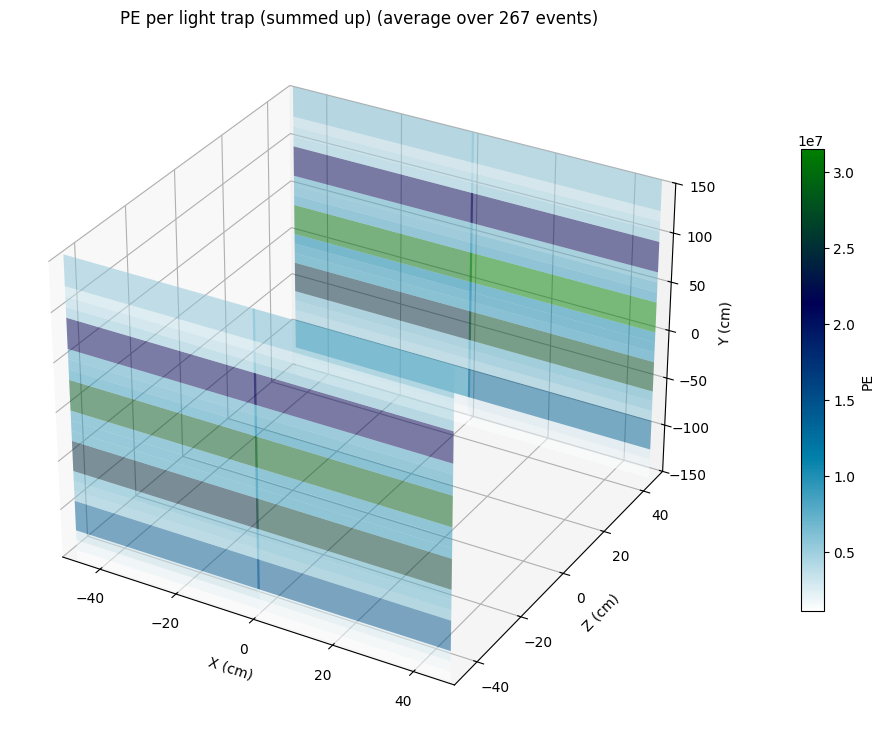

In [39]:
####PLOTE THE LIGHT SUMS per Trap!!
#### the following code snippets are not included in the next steps of the process yet


import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

#pde_percent =  light_trap_pe_sums # Convert to percent
pde_percent = expected_total
pde_percent = np.asarray(pde_percent, dtype=float)  # avoid object dtype
#print(pde_percent)
# robust vmin/vmax
finite = np.isfinite(pde_percent)
if not np.any(finite):
    raise ValueError("All PDE % values are NaN/inf; nothing to normalize.")
vmin = np.nanmin(pde_percent)
vmax = np.nanmax(pde_percent)
print(vmax)
print(vmin)
if vmin == vmax:
    # avoid divide-by-zero in normalization
    vmax = vmin + 1e-12

norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap = plt.cm.ocean_r
cmap.set_bad('lightgray', alpha=0.6)  # how NaNs will look

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    c = cmap(norm(value))           # NaNs map to the “bad” color
    rect = Poly3DCollection([corners], facecolors=c, alpha=0.5)
    ax.add_collection3d(rect)
# Set up colormap and normalization range
"""
vmin = np.min(pde_percent)
vmax = np.max(pde_percent)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.ocean_r

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot rectangles
for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    color = cmap(norm(value))  # Map actual PDE % through normalized colormap
    print(norm(value))
    rect = Poly3DCollection([corners], color=color, alpha=0.5)
    ax.add_collection3d(rect)
"""
# Colorbar setup — use the same normalization!
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Just to make matplotlib happy
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('PE')

# Axes setup
ax.set_xlabel('X (cm)')
ax.set_ylabel('Z (cm)')
ax.set_zlabel('Y (cm)')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-150, 150)
ax.set_title(f'PE per light trap (summed up) (average over {max_events} events)')

plt.show()

46941.68247190593
3720.9217160818566


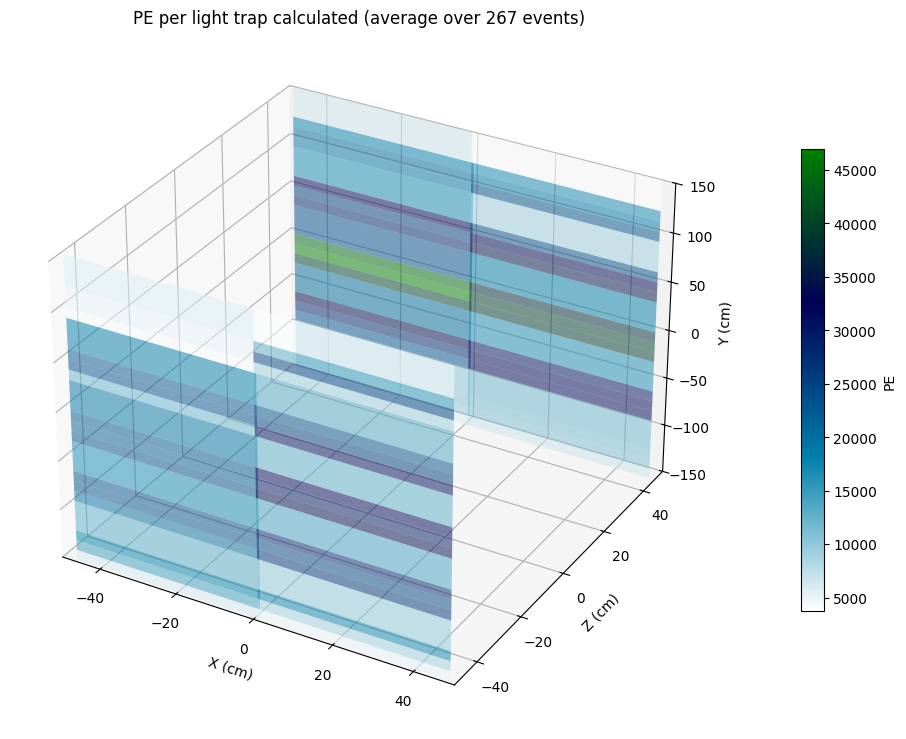

In [40]:
####PLOTE THE LIGHT CALCULATED per Trap!!
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

#pde_percent =  detected_all# light_trap_pe_sums # Convert to percent

pde_percent = real_sum_total_pe
pde_percent = np.asarray(pde_percent, dtype=float)  # avoid object dtype
#print(pde_percent)
# robust vmin/vmax
finite = np.isfinite(pde_percent)
if not np.any(finite):
    raise ValueError("All PDE % values are NaN/inf; nothing to normalize.")
vmin = np.nanmin(pde_percent)
vmax = np.nanmax(pde_percent)
print(vmax)
print(vmin)
if vmin == vmax:
    # avoid divide-by-zero in normalization
    vmax = vmin + 1e-12

norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap = plt.cm.ocean_r
cmap.set_bad('lightgray', alpha=0.6)  # how NaNs will look

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    c = cmap(norm(value))           # NaNs map to the “bad” color
    rect = Poly3DCollection([corners], facecolors=c, alpha=0.5)
    ax.add_collection3d(rect)
# Set up colormap and normalization range
"""
vmin = np.min(pde_percent)
vmax = np.max(pde_percent)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.ocean_r

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot rectangles
for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    color = cmap(norm(value))  # Map actual PDE % through normalized colormap
    print(norm(value))
    rect = Poly3DCollection([corners], color=color, alpha=0.5)
    ax.add_collection3d(rect)
"""
# Colorbar setup — use the same normalization!
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Just to make matplotlib happy
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('PE')

# Axes setup
ax.set_xlabel('X (cm)')
ax.set_ylabel('Z (cm)')
ax.set_zlabel('Y (cm)')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-150, 150)
ax.set_title(f'PE per light trap calculated (average over {max_events} events)')

plt.show()

In [41]:
fig = go.Figure()
pde_percent = pde_avg * 100  # Convert to percent
# Normalize color values

if not np.any(finite):
    raise ValueError("All PDE % values are NaN/inf; nothing to normalize.")
vmin = np.nanmin(pde_percent)
vmax = np.nanmax(pde_percent)
print(vmax)
print(vmin)
if vmin == vmax:
    # avoid divide-by-zero in normalization
    vmax = vmin + 1e-12

colors_norm = (pde_percent - vmin) / (vmax - vmin + 1e-8)
cmap = matplotlib.colormaps['ocean_r']

# Plot each trap as a 3D rectangle
for result, norm_val in zip(all_results, colors_norm):
    x0, y0, x1, y1, z_det, *_ = result
    x = [x0, x1, x1, x0, x0]
    y = [y0, y0, y1, y1, y0]
    z = [z_det]*5

    # Get RGBA color from matplotlib colormap, convert to hex
    rgba = cmap(norm_val)
    color = f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, 0.6)'

    fig.add_trace(go.Scatter3d(
        x=x, y=z, z=y,  # Note: plotly uses (x, y, z), you have (x, z, y)
        mode='lines',
        line=dict(color='gray', width=2),
        surfaceaxis=1,  # tells plotly to fill in the shape
        # fill='toself',
        showlegend=False,
        surfacecolor=color,
        hoverinfo='none'
    ))

# Step 1: Convert 'ocean_r' colormap to Plotly colorscale
def mpl_to_plotly(cmap_name, n=256):
    cmap = matplotlib.colormaps['ocean_r']
    colorscale = []
    for i in range(cmap.N):
        r, g, b, _ = cmap(i)
        colorscale.append([i / (cmap.N - 1), f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})'])
    return colorscale

colorscale = mpl_to_plotly('ocean_r')
# Create a dummy scatter for the colorbar
dummy_scatter = go.Scatter3d(
    x=[None], y=[None], z=[None],  # invisible
    mode='markers',
    marker=dict(
        size=0.0001,
        color=[vmin, vmax],  # use full color range
        colorscale=colorscale,
        cmin=vmin,
        cmax=vmax,
        colorbar=dict(
            title='PDE (%)',
            thickness=20,
            len=0.75
        )
    ),
    showlegend=False
)
fig.add_trace(dummy_scatter)

# Set up layout
fig.update_layout(
    scene=dict(
        xaxis_title='X (cm)',
        yaxis_title='Z (cm)',
        zaxis_title='Y (cm)',
        xaxis=dict(range=[-50, 50]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[-150, 150]),
    ),
    title=f'PDE per light trap (average over {max_events} events)',
    legend=None,
    width=900,
    height=800,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

0.8809211910869034
0.04009915888161199
